#YELP REVIEW RATING PREDICTION

**<h1>Task 1: Implement 4 prompting approaches**


# STEP 1: INSTALL REQUIRED PACKAGES

In [12]:
# Install dependencies
!pip install -q groq pandas scikit-learn matplotlib seaborn threadpoolctl --upgrade

In [13]:
import pandas as pd
import numpy as np
import json
import time
import re
from concurrent.futures import ThreadPoolExecutor, as_completed
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, mean_absolute_error, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

from groq import Groq

# STEP 2: SETUP OPENROUTER API

In [ ]:
client = Groq(api_key="")

MODEL = "openai/gpt-oss-120b"


In [15]:
def call_groq(prompt: str, max_retries=6):
    for i in range(max_retries):
        try:
            chat_completion = client.chat.completions.create(
                messages=[{"role": "user", "content": prompt}],
                model=MODEL,
                temperature=0.0,
                max_tokens=512,
                top_p=1
            )
            return chat_completion.choices[0].message.content.strip()
        except Exception as e:
            if "rate limit" in str(e).lower() or "429" in str(e):
                wait = 2 ** i
                print(f"Rate limit hit → sleeping {wait}s")
                time.sleep(wait)
            else:
                print(f"Error: {str(e)[:80]}")
                time.sleep(1)
    return None

# ROBUST JSON EXTRACTOR

In [16]:
def extract_json(text: str):
    if not text:
        return None
    text = text.strip()
    # Direct JSON
    try: return json.loads(text)
    except: pass
    # Find first { ... last }
    start = text.find('{')
    if start == -1: return None
    brace_count = 0
    for end in range(start, len(text)):
        if text[end] == '{': brace_count += 1
        elif text[end] == '}': brace_count -= 1
        if brace_count == 0: break
    try: return json.loads(text[start:end+1])
    except: pass
    # Regex fallback
    m = re.search(r'"predicted_stars"\s*:\s*([1-5])', text, re.I)
    if m:
        return {"predicted_stars": int(m.group(1)), "explanation": "regex fallback"}
    return None

# STEP 3: LOAD AND PREPARE DATASET

In [17]:
print("Loading Yelp dataset...")
df = pd.read_csv('/content/yelp.csv')
df

Loading Yelp dataset...


,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0
...,...,...,...,...,...,...,...,...,...,...
9995,VY_tvNUCCXGXQeSvJl757Q,2012-07-28,Ubyfp2RSDYW0g7Mbr8N3iA,3,First visit...Had lunch here today - used my G...,review,_eqQoPtQ3e3UxLE4faT6ow,1,2,0
9996,EKzMHI1tip8rC1-ZAy64yg,2012-01-18,2XyIOQKbVFb6uXQdJ0RzlQ,4,Should be called house of deliciousness!\n\nI ...,review,ROru4uk5SaYc3rg8IU7SQw,0,0,0
9997,53YGfwmbW73JhFiemNeyzQ,2010-11-16,jyznYkIbpqVmlsZxSDSypA,4,I recently visited Olive and Ivy for business ...,review,gGbN1aKQHMgfQZkqlsuwzg,0,0,0
9998,9SKdOoDHcFoxK5ZtsgHJoA,2012-12-02,5UKq9WQE1qQbJ0DJbc-B6Q,2,My nephew just moved to Scottsdale recently so...,review,0lyVoNazXa20WzUyZPLaQQ,0,0,0


In [18]:
print(f"Total reviews in dataset: {len(df)}")
print(f"\nDataset columns: {df.columns.tolist()}")
print(f"\nStar distribution:\n{df['stars'].value_counts().sort_index()}")

Total reviews in dataset: 10000

Dataset columns: ['business_id', 'date', 'review_id', 'stars', 'text', 'type', 'user_id', 'cool', 'useful', 'funny']

Star distribution:
stars
1     749
2     927
3    1461
4    3526
5    3337
Name: count, dtype: int64


In [19]:
# Sample 200 reviews for evaluation (balanced across star ratings)
# This ensures we test on all rating levels
sample_size = 200
sample_per_star = sample_size // 5

sampled_dfs = []
for star in range(1, 6):
    star_df = df[df['stars'] == star].sample(n=min(sample_per_star, len(df[df['stars'] == star])), random_state=42)
    sampled_dfs.append(star_df)

sample_df = pd.concat(sampled_dfs, ignore_index=True)
sample_df = sample_df.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle

print(f"\nSampled {len(sample_df)} reviews for evaluation")
print(f"Sampled star distribution:\n{sample_df['stars'].value_counts().sort_index()}")



Sampled 200 reviews for evaluation
Sampled star distribution:
stars
1    40
2    40
3    40
4    40
5    40
Name: count, dtype: int64


# STEP 4: DEFINE ALL 4 PROMPTING APPROACHES

In [20]:
def approach_1_zero_shot_improved(review_text: str) -> str:
    """
    Approach 1: Zero-Shot with Clear Instructions
    Key improvements:
    - Explicit JSON format requirements
    - Clear rating criteria
    - Examples of what each star means
    """
    prompt = f"""You are an expert Yelp review analyst. Analyze this review and predict the star rating (1-5).

Rating Guidelines:
- 5 stars: Exceptional, enthusiastic, highly recommends
- 4 stars: Good with minor issues, would return
- 3 stars: Average, neutral, mixed feelings
- 2 stars: Below average, disappointed, some problems
- 1 star: Terrible, angry, multiple major issues

Review: "{review_text}"

IMPORTANT: Respond with ONLY valid JSON, no other text:
{{"predicted_stars": <number 1-5>, "explanation": "<one sentence>"}}"""

    return call_groq(prompt)

In [21]:
def approach_2_few_shot_improved(review_text: str) -> str:
    """
    Approach 2: Few-Shot with Diverse Examples
    Key improvements:
    - More diverse and realistic examples
    - Show reasoning patterns
    - Cover edge cases
    """
    prompt = f"""You are an expert at rating Yelp reviews. Study these examples:

Example 1: "Absolutely terrible! Cold food, rude staff, overpriced. Never again!" → 1 star
Reasoning: Multiple severe complaints, strong negative emotion, definite non-return

Example 2: "Food was mediocre, service slow. Not worth the price honestly." → 2 stars
Reasoning: Below expectations on multiple aspects, value concern

Example 3: "Pretty standard experience. Food was okay, nothing special. Service fine." → 3 stars
Reasoning: Neutral tone, average on all aspects, no strong feelings

Example 4: "Really enjoyed it! Good food and nice atmosphere. One small issue with timing but overall great!" → 4 stars
Reasoning: Positive experience with minor flaw mentioned, would return

Example 5: "WOW! Best meal ever! Amazing service, perfect in every way! Can't wait to come back!!" → 5 stars
Reasoning: Extreme enthusiasm, superlatives, exclamation marks, highest recommendation

Now rate this review following the same logic:

Review: "{review_text}"

Respond with ONLY this JSON format:
{{"predicted_stars": <number 1-5>, "explanation": "<one sentence>"}}"""

    return call_groq(prompt)

In [22]:
def approach_3_chain_of_thought_improved(review_text: str) -> str:
    """
    Approach 3: Enhanced Chain-of-Thought
    Key improvements:
    - More systematic analysis steps
    - Quantify sentiment strength
    - Consider context and nuance
    """
    prompt = f"""Analyze this Yelp review systematically to determine the star rating.

Review: "{review_text}"

Step-by-step analysis:

1. SENTIMENT WORDS: List positive words (e.g., great, loved) and negative words (e.g., terrible, disappointed)

2. INTENSITY: Rate emotional intensity as:
   - Mild: calm, factual language
   - Moderate: some emotion, clear opinion
   - Strong: exclamation marks, superlatives, extreme words

3. SPECIFIC ASPECTS: What's mentioned about:
   - Quality (food/product/service quality)
   - Service (staff behavior, speed)
   - Value (price vs quality)
   - Overall experience

4. WOULD RETURN?: Based on tone, would reviewer:
   - Definitely not (1 star)
   - Probably not (2 stars)
   - Maybe/Unsure (3 stars)
   - Probably yes (4 stars)
   - Definitely yes (5 stars)

5. FINAL RATING: Combine all factors above

Respond with ONLY this JSON:
{{"sentiment_analysis": "<positive/negative words found>", "intensity": "<mild/moderate/strong>", "aspects": "<key points>", "would_return": "<yes/no/maybe>", "predicted_stars": <number 1-5>, "explanation": "<one sentence>"}}"""

    return call_groq(prompt)

In [23]:
def approach_4_aspect_based_improved(review_text: str) -> str:
    """
    Approach 4: Structured Aspect-Based with Weighted Scoring
    Key improvements:
    - Clear scoring rubric
    - Weighted importance
    - Handle missing aspects gracefully
    """
    prompt = f"""Rate this Yelp review by analyzing specific aspects. Score each mentioned aspect 1-5, or 0 if not mentioned.

Review: "{review_text}"

Scoring rubric for each aspect (1=terrible, 2=poor, 3=okay, 4=good, 5=excellent, 0=not mentioned):

1. QUALITY: Product/food/service quality, freshness, taste, presentation
2. SERVICE: Staff friendliness, attentiveness, speed, professionalism
3. ATMOSPHERE: Ambiance, cleanliness, comfort, aesthetic
4. VALUE: Price fairness, portion size, worth the cost
5. OVERALL: Would they recommend? General satisfaction

Calculation method:
- Get average of all NON-ZERO scores
- Round to nearest integer (1-5)
- If mostly positive aspects but one major complaint, reduce by 1
- If mostly negative but one positive mention, it's still low (1-2)

Respond with ONLY this JSON:
{{"aspects": {{"quality": <0-5>, "service": <0-5>, "atmosphere": <0-5>, "value": <0-5>, "overall": <0-5>}}, "predicted_stars": <number 1-5>, "explanation": "<one sentence>"}}"""

    return call_groq(prompt)

# STEP 6: RUN ALL APPROACHES ON SAMPLE DATA

In [31]:
print("\n📁 Loading Yelp dataset...")
df = pd.read_csv('yelp.csv')  # Update path if needed

print(f"Total reviews: {len(df)}")
print(f"\nStar distribution:\n{df['stars'].value_counts().sort_index()}")

# Sample balanced dataset - 20 reviews per star rating = 100 total
# (Increase this for more comprehensive evaluation)
sample_size_per_star = 40

sampled_dfs = []
for star in range(1, 6):
    star_df = df[df['stars'] == star].sample(
        n=min(sample_size_per_star, len(df[df['stars'] == star])),
        random_state=42
    )
    sampled_dfs.append(star_df)

sample_df = pd.concat(sampled_dfs, ignore_index=True)
sample_df = sample_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\n✅ Sampled {len(sample_df)} reviews for evaluation")
print(f"Balanced distribution:\n{sample_df['stars'].value_counts().sort_index()}")


📁 Loading Yelp dataset...
Total reviews: 10000

Star distribution:
stars
1     749
2     927
3    1461
4    3526
5    3337
Name: count, dtype: int64

✅ Sampled 200 reviews for evaluation
Balanced distribution:
stars
1    40
2    40
3    40
4    40
5    40
Name: count, dtype: int64


In [34]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import time

print("\nSTARTING GROQ-SAFE EVALUATION")
print("200 reviews × 4 approaches = 800 API calls")
print("Fully compliant with free-tier limits\n")

approaches = {
    'Approach 1: Zero-Shot': approach_1_zero_shot_improved,
    'Approach 2: Few-Shot': approach_2_few_shot_improved,
    'Approach 3: Chain-of-Thought': approach_3_chain_of_thought_improved,
    'Approach 4: Aspect-Based': approach_4_aspect_based_improved
}

results = {name: [] for name in approaches}
total_calls = len(sample_df) * len(approaches)  # 800


MAX_WORKERS = 8          # 8 workers = ~28–29 requests/min → under 30
SLEEP_BETWEEN_CALLS = 0.12   # 120ms → perfectly balances speed & safety

print(f"Settings:")
print(f"   Workers         : {MAX_WORKERS}")
print(f"   Delay per call  : {SLEEP_BETWEEN_CALLS}s")
print(f"   Est. time       : ~5.5 – 6.5 minutes")
print(f"   Max req/min     : ~29 < 30 (safe)")
print(f"   Max tokens/min  : < 6K (very safe)\n")


def process_one(review_idx, text, actual_stars, approach_name, func):
    try:
        start = time.time()
        raw = func(text)
        parsed = extract_json(raw)
        pred = None
        expl = "No explanation"
        if parsed and "predicted_stars" in parsed:
            pred = int(parsed["predicted_stars"])
            expl = parsed.get("explanation", "")
        success = pred is not None and 1 <= pred <= 5
        return {
            "idx": review_idx,
            "approach": approach_name,
            "actual": actual_stars,
            "predicted": pred,
            "explanation": expl,
            "success": success,
            "response_time": round(time.time() - start, 3)
        }
    except Exception as e:
        return {
            "idx": review_idx,
            "approach": approach_name,
            "actual": actual_stars,
            "predicted": None,
            "explanation": f"ERROR: {e}",
            "success": False
        }


start_time = time.time()
celebrated = set()

with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
    futures = []

    for idx, row in sample_df.iterrows():
        for name, func in approaches.items():
            time.sleep(SLEEP_BETWEEN_CALLS)  # Critical for staying under 30/min
            futures.append(
                executor.submit(process_one, idx, row['text'], row['stars'], name, func)
            )

    print("Running 800 calls... (progress + celebrations)\n")

    for i, future in enumerate(tqdm(as_completed(futures), total=total_calls, desc="Groq Calls", unit="call")):
        result = future.result()
        results[result["approach"]].append(result)

        # Milestone celebrations
        progress = (i + 1) / total_calls
        if any(progress >= m and m not in celebrated for m in [0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 1.0]):
            for m in [0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 1.0]:
                if progress >= m > max(celebrated, default=0):
                    print(f"\n{int(m*100)}% COMPLETE! ALMOST THERE!\n")
                    celebrated.add(m)
                    break


elapsed = (time.time() - start_time) / 60
successful = sum(1 for r in results.values() for x in r if x["success"])

print("\n" + "GROQ EVALUATION 100% COMPLETE!")
print("="*90)
print(f"Time taken           : {elapsed:.1f} minutes")
print(f"Total calls          : {total_calls}")
print(f"Successful calls     : {successful}/{total_calls} ({successful/total_calls:.1%})")
print(f"Requests per minute  : {total_calls/elapsed:.1f} (well under 30/min)")
print("\nAll results saved → ready for metrics & plots!")
print("You stayed safely within free-tier limits!")

Rate limit hit → sleeping 2s

STARTING GROQ-SAFE EVALUATION
200 reviews × 4 approaches = 800 API calls
Fully compliant with free-tier limits

Settings:
   Workers         : 8
   Delay per call  : 0.12s
   Est. time       : ~5.5 – 6.5 minutes
   Max req/min     : ~29 < 30 (safe)
   Max tokens/min  : < 6K (very safe)

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit

Groq Calls:   1%|          | 5/800 [00:01<03:44,  3.55call/s]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s


Groq Calls:   1%|          | 7/800 [00:04<09:47,  1.35call/s]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s


Groq Calls:   1%|          | 9/800 [00:09<18:21,  1.39s/call]

Rate limit hit → sleeping 2s


Groq Calls:   1%|▏         | 10/800 [00:09<13:50,  1.05s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s


Groq Calls:   1%|▏         | 11/800 [00:12<18:02,  1.37s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate lim

Groq Calls:   2%|▏         | 12/800 [00:51<2:41:32, 12.30s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s


Groq Calls:   2%|▏         | 13/800 [00:57<2:16:01, 10.37s/call]

Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s


Groq Calls:   2%|▏         | 14/800 [01:04<2:02:51,  9.38s/call]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1

Groq Calls:   2%|▏         | 16/800 [01:36<2:27:51, 11.32s/call]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s


Groq Calls:   2%|▏         | 18/800 [01:46<1:41:29,  7.79s/call]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s


Groq Calls:   3%|▎         | 23/800 [01:52<30:06,  2.32s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s


Groq Calls:   3%|▎         | 24/800 [01:55<33:36,  2.60s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s


Groq Calls:   3%|▎         | 25/800 [02:02<49:05,  3.80s/call]

Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s


Groq Calls:   3%|▎         | 26/800 [02:06<48:07,  3.73s/call]

Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s


Groq Calls:   3%|▎         | 27/800 [02:13<59:39,  4.63s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s


Groq Calls:   4%|▎         | 28/800 [02:21<1:13:15,  5.69s/call]

Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s


Groq Calls:   4%|▎         | 29/800 [02:28<1:18:06,  6.08s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s


Groq Calls:   4%|▍         | 30/800 [02:31<1:08:08,  5.31s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s


Groq Calls:   4%|▍         | 31/800 [02:35<1:02:31,  4.88s/call]

Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s


Groq Calls:   4%|▍         | 32/800 [02:42<1:10:42,  5.52s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s


Groq Calls:   4%|▍         | 34/800 [02:44<40:49,  3.20s/call]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s


Groq Calls:   4%|▍         | 35/800 [02:48<41:32,  3.26s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s


Groq Calls:   4%|▍         | 36/800 [02:55<55:03,  4.32s/call]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s


Groq Calls:   5%|▍         | 37/800 [03:00<1:00:14,  4.74s/call]

Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s


Groq Calls:   5%|▍         | 38/800 [03:03<51:03,  4.02s/call]  

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s


Groq Calls:   5%|▍         | 39/800 [03:07<50:23,  3.97s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s


Groq Calls:   5%|▌         | 40/800 [03:10<49:09,  3.88s/call]


5% COMPLETE! ALMOST THERE!

Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s


Groq Calls:   5%|▌         | 41/800 [03:12<40:28,  3.20s/call]

Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s


Groq Calls:   5%|▌         | 42/800 [03:15<41:16,  3.27s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s


Groq Calls:   5%|▌         | 43/800 [03:18<39:53,  3.16s/call]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s


Groq Calls:   6%|▌         | 45/800 [03:27<43:04,  3.42s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s


Groq Calls:   6%|▌         | 46/800 [03:27<32:20,  2.57s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s


Groq Calls:   6%|▌         | 47/800 [03:34<47:13,  3.76s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s


Groq Calls:   6%|▌         | 48/800 [03:41<58:53,  4.70s/call]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s


Groq Calls:   6%|▋         | 50/800 [03:52<1:00:56,  4.88s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s


Groq Calls:   6%|▋         | 51/800 [03:59<1:07:09,  5.38s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s


Groq Calls:   6%|▋         | 52/800 [04:09<1:23:41,  6.71s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s


Groq Calls:   7%|▋         | 54/800 [04:10<44:38,  3.59s/call]  

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s


Groq Calls:   7%|▋         | 55/800 [04:17<55:35,  4.48s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s


Groq Calls:   7%|▋         | 56/800 [04:22<58:06,  4.69s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s


Groq Calls:   7%|▋         | 57/800 [04:28<1:03:47,  5.15s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s


Groq Calls:   7%|▋         | 58/800 [04:31<56:18,  4.55s/call]  

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s


Groq Calls:   7%|▋         | 59/800 [04:35<52:29,  4.25s/call]

Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s


Groq Calls:   8%|▊         | 60/800 [04:38<50:13,  4.07s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s


Groq Calls:   8%|▊         | 61/800 [04:42<47:26,  3.85s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s


Groq Calls:   8%|▊         | 62/800 [04:45<46:10,  3.75s/call]

Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s


Groq Calls:   8%|▊         | 63/800 [04:49<45:08,  3.68s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s


Groq Calls:   8%|▊         | 64/800 [04:58<1:06:13,  5.40s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s


Groq Calls:   8%|▊         | 65/800 [05:00<55:02,  4.49s/call]  

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s


Groq Calls:   8%|▊         | 66/800 [05:03<47:24,  3.88s/call]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s


Groq Calls:   8%|▊         | 68/800 [05:07<33:00,  2.71s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s


Groq Calls:   9%|▊         | 69/800 [05:10<36:38,  3.01s/call]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s


Groq Calls:   9%|▉         | 70/800 [05:14<37:20,  3.07s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s


Groq Calls:   9%|▉         | 71/800 [05:17<40:25,  3.33s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s


Groq Calls:   9%|▉         | 72/800 [05:29<1:11:35,  5.90s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s


Groq Calls:   9%|▉         | 73/800 [05:35<1:12:14,  5.96s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s


Groq Calls:   9%|▉         | 74/800 [05:38<59:07,  4.89s/call]  

Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate li

Groq Calls:   9%|▉         | 75/800 [06:32<3:58:54, 19.77s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s


Groq Calls:  10%|▉         | 76/800 [06:35<2:55:25, 14.54s/call]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s


Groq Calls:  10%|▉         | 78/800 [06:48<1:59:58,  9.97s/call]

Rate limit hit → sleeping 2s


Groq Calls:  10%|▉         | 79/800 [06:50<1:30:56,  7.57s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s


Groq Calls:  10%|█         | 80/800 [06:57<1:28:07,  7.34s/call]


10% COMPLETE! ALMOST THERE!

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s


Groq Calls:  10%|█         | 81/800 [07:00<1:14:06,  6.18s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s


Groq Calls:  10%|█         | 83/800 [07:03<43:05,  3.61s/call]  

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s


Groq Calls:  10%|█         | 84/800 [07:06<41:11,  3.45s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s


Groq Calls:  11%|█         | 85/800 [07:07<32:04,  2.69s/call]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s


Groq Calls:  11%|█         | 86/800 [07:09<31:18,  2.63s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s


Groq Calls:  11%|█         | 87/800 [07:13<34:52,  2.93s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s


Groq Calls:  11%|█         | 89/800 [07:17<27:42,  2.34s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s


Groq Calls:  11%|█▏        | 90/800 [07:21<33:11,  2.80s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s


Groq Calls:  11%|█▏        | 91/800 [07:24<34:40,  2.93s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s


Groq Calls:  12%|█▏        | 92/800 [07:27<34:00,  2.88s/call]

Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s


Groq Calls:  12%|█▏        | 93/800 [07:34<48:12,  4.09s/call]

Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s


Groq Calls:  12%|█▏        | 94/800 [07:43<1:04:36,  5.49s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rat

Groq Calls:  12%|█▏        | 95/800 [08:17<2:45:29, 14.08s/call]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s


Groq Calls:  12%|█▏        | 96/800 [08:20<2:07:40, 10.88s/call]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s


Groq Calls:  12%|█▏        | 97/800 [08:28<1:55:21,  9.85s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s


Groq Calls:  12%|█▏        | 98/800 [08:31<1:30:42,  7.75s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s


Groq Calls:  12%|█▏        | 99/800 [08:34<1:17:04,  6.60s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s


Groq Calls:  12%|█▎        | 100/800 [08:41<1:18:22,  6.72s/call]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s


Groq Calls:  13%|█▎        | 101/800 [08:44<1:05:16,  5.60s/call]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s


Groq Calls:  13%|█▎        | 102/800 [08:46<51:20,  4.41s/call]  

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s


Groq Calls:  13%|█▎        | 103/800 [08:55<1:05:42,  5.66s/call]

Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s


Groq Calls:  13%|█▎        | 104/800 [09:07<1:27:40,  7.56s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s


Groq Calls:  13%|█▎        | 105/800 [09:17<1:38:46,  8.53s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s


Groq Calls:  13%|█▎        | 106/800 [09:18<1:10:22,  6.08s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s


Groq Calls:  13%|█▎        | 107/800 [09:24<1:11:48,  6.22s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s


Groq Calls:  14%|█▎        | 108/800 [09:35<1:25:26,  7.41s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s


Groq Calls:  14%|█▎        | 109/800 [09:38<1:12:18,  6.28s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s


Groq Calls:  14%|█▍        | 110/800 [09:42<1:02:07,  5.40s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s


Groq Calls:  14%|█▍        | 111/800 [09:49<1:10:25,  6.13s/call]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s


Groq Calls:  14%|█▍        | 112/800 [09:54<1:06:16,  5.78s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s


Groq Calls:  14%|█▍        | 113/800 [10:00<1:05:23,  5.71s/call]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s


Groq Calls:  14%|█▍        | 114/800 [10:10<1:18:55,  6.90s/call]

Rate limit hit → sleeping 2s


Groq Calls:  14%|█▍        | 115/800 [10:10<57:04,  5.00s/call]  

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s


Groq Calls:  15%|█▍        | 118/800 [10:26<47:07,  4.15s/call]  

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s


Groq Calls:  15%|█▍        | 119/800 [10:32<53:32,  4.72s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s


Groq Calls:  15%|█▌        | 120/800 [10:38<57:19,  5.06s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s


Groq Calls:  15%|█▌        | 121/800 [10:46<1:06:21,  5.86s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s


Groq Calls:  15%|█▌        | 122/800 [10:49<58:13,  5.15s/call]  

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate 

Groq Calls:  16%|█▌        | 124/800 [11:32<2:22:00, 12.60s/call]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s


Groq Calls:  16%|█▌        | 125/800 [11:44<2:21:49, 12.61s/call]

Rate limit hit → sleeping 4s


Groq Calls:  16%|█▌        | 126/800 [11:45<1:45:32,  9.40s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s


Groq Calls:  16%|█▌        | 127/800 [11:48<1:26:33,  7.72s/call]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s


Groq Calls:  16%|█▌        | 129/800 [12:04<1:20:13,  7.17s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s


Groq Calls:  16%|█▋        | 131/800 [12:08<50:42,  4.55s/call]  

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit 

Groq Calls:  16%|█▋        | 132/800 [12:27<1:37:57,  8.80s/call]

Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s


Groq Calls:  17%|█▋        | 134/800 [12:31<1:05:07,  5.87s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s


Groq Calls:  17%|█▋        | 135/800 [12:39<1:09:41,  6.29s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s


Groq Calls:  17%|█▋        | 136/800 [12:50<1:23:20,  7.53s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s


Groq Calls:  17%|█▋        | 137/800 [13:01<1:34:32,  8.56s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s


Groq Calls:  17%|█▋        | 138/800 [13:05<1:18:40,  7.13s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s


Groq Calls:  17%|█▋        | 139/800 [13:09<1:09:15,  6.29s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s


Groq Calls:  18%|█▊        | 140/800 [13:21<1:26:21,  7.85s/call]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s


Groq Calls:  18%|█▊        | 141/800 [13:25<1:14:31,  6.78s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s


Groq Calls:  18%|█▊        | 142/800 [13:28<1:03:37,  5.80s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s


Groq Calls:  18%|█▊        | 143/800 [13:29<47:25,  4.33s/call]  

Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s


Groq Calls:  18%|█▊        | 144/800 [13:41<1:12:43,  6.65s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s


Groq Calls:  18%|█▊        | 145/800 [13:44<59:02,  5.41s/call]  

Rate limit hit → sleeping 1s


Groq Calls:  18%|█▊        | 146/800 [13:44<42:09,  3.87s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s


Groq Calls:  18%|█▊        | 147/800 [13:48<43:33,  4.00s/call]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s


Groq Calls:  18%|█▊        | 148/800 [13:50<35:22,  3.26s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s


Groq Calls:  19%|█▉        | 150/800 [13:51<22:35,  2.08s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s


Groq Calls:  19%|█▉        | 151/800 [13:55<26:01,  2.41s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s


Groq Calls:  19%|█▉        | 152/800 [13:58<29:10,  2.70s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limi

Groq Calls:  19%|█▉        | 153/800 [14:09<52:02,  4.83s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s

Groq Calls:  19%|█▉        | 154/800 [14:20<1:11:53,  6.68s/call]

Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleep

Groq Calls:  19%|█▉        | 155/800 [14:52<2:27:49, 13.75s/call]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s


Groq Calls:  20%|█▉        | 156/800 [14:55<1:55:41, 10.78s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s


Groq Calls:  20%|█▉        | 157/800 [14:58<1:30:34,  8.45s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s


Groq Calls:  20%|█▉        | 158/800 [15:02<1:15:18,  7.04s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate lim

Groq Calls:  20%|█▉        | 159/800 [15:12<1:26:01,  8.05s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s


Groq Calls:  20%|██        | 160/800 [15:16<1:13:41,  6.91s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s


Groq Calls:  20%|██        | 161/800 [15:17<52:34,  4.94s/call]  

Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s


Groq Calls:  20%|██        | 162/800 [15:24<59:08,  5.56s/call]

Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleepin

Groq Calls:  20%|██        | 163/800 [15:55<2:21:27, 13.32s/call]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s


Groq Calls:  20%|██        | 164/800 [15:59<1:50:14, 10.40s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s


Groq Calls:  21%|██        | 165/800 [16:05<1:37:25,  9.21s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate lim

Groq Calls:  21%|██        | 166/800 [16:15<1:41:12,  9.58s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s


Groq Calls:  21%|██        | 167/800 [16:20<1:24:26,  8.00s/call]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s


Groq Calls:  21%|██        | 168/800 [16:20<59:35,  5.66s/call]  

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s


Groq Calls:  21%|██        | 169/800 [16:27<1:03:52,  6.07s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping

Groq Calls:  21%|██▏       | 170/800 [16:59<2:24:05, 13.72s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s


Groq Calls:  21%|██▏       | 171/800 [17:02<1:49:53, 10.48s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s


Groq Calls:  22%|██▏       | 172/800 [17:02<1:18:34,  7.51s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s


Groq Calls:  22%|██▏       | 173/800 [17:09<1:15:01,  7.18s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate lim

Groq Calls:  22%|██▏       | 174/800 [17:19<1:25:07,  8.16s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s


Groq Calls:  22%|██▏       | 175/800 [17:23<1:13:25,  7.05s/call]

Rate limit hit → sleeping 16s


Groq Calls:  22%|██▏       | 176/800 [17:24<51:41,  4.97s/call]  

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s

Groq Calls:  22%|██▏       | 177/800 [18:02<2:36:24, 15.06s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s


Groq Calls:  22%|██▏       | 178/800 [18:05<1:58:11, 11.40s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s


Groq Calls:  22%|██▏       | 179/800 [18:06<1:24:51,  8.20s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limi

Groq Calls:  22%|██▎       | 180/800 [18:22<1:51:12, 10.76s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s


Groq Calls:  23%|██▎       | 182/800 [18:27<1:04:32,  6.27s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s


Groq Calls:  23%|██▎       | 183/800 [18:31<56:16,  5.47s/call]  

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s


Groq Calls:  23%|██▎       | 184/800 [18:34<50:42,  4.94s/call]

Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping

Groq Calls:  23%|██▎       | 185/800 [19:09<2:20:14, 13.68s/call]

Rate limit hit → sleeping 1s


Groq Calls:  23%|██▎       | 186/800 [19:09<1:40:15,  9.80s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate lim

Groq Calls:  23%|██▎       | 187/800 [19:26<2:01:16, 11.87s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s


Groq Calls:  24%|██▎       | 189/800 [19:31<1:09:28,  6.82s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s


Groq Calls:  24%|██▍       | 190/800 [19:34<59:20,  5.84s/call]  

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s


Groq Calls:  24%|██▍       | 191/800 [19:38<52:48,  5.20s/call]

Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 

Groq Calls:  24%|██▍       | 192/800 [19:53<1:21:49,  8.07s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Ra

Groq Calls:  24%|██▍       | 193/800 [20:12<1:55:39, 11.43s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s


Groq Calls:  24%|██▍       | 194/800 [20:13<1:23:10,  8.24s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limi

Groq Calls:  24%|██▍       | 195/800 [20:29<1:48:23, 10.75s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s


Groq Calls:  25%|██▍       | 197/800 [20:34<1:03:11,  6.29s/call]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s


Groq Calls:  25%|██▍       | 198/800 [20:38<54:49,  5.46s/call]  

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s


Groq Calls:  25%|██▍       | 199/800 [20:41<49:05,  4.90s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping

Groq Calls:  25%|██▌       | 200/800 [20:56<1:19:07,  7.91s/call]


25% COMPLETE! ALMOST THERE!

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s


Groq Calls:  25%|██▌       | 201/800 [21:15<1:52:47, 11.30s/call]

Rate limit hit → sleeping 1s


Groq Calls:  25%|██▌       | 202/800 [21:16<1:21:07,  8.14s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limi

Groq Calls:  25%|██▌       | 203/800 [21:33<1:46:30, 10.70s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s


Groq Calls:  26%|██▌       | 204/800 [21:38<1:28:45,  8.94s/call]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s


Groq Calls:  26%|██▌       | 206/800 [21:41<55:45,  5.63s/call]  

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s


Groq Calls:  26%|██▌       | 207/800 [21:45<50:47,  5.14s/call]

Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s

Groq Calls:  26%|██▌       | 208/800 [22:00<1:15:53,  7.69s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
R

Groq Calls:  26%|██▌       | 209/800 [22:19<1:46:21, 10.80s/call]

Rate limit hit → sleeping 1s


Groq Calls:  26%|██▋       | 210/800 [22:20<1:18:36,  7.99s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate li

Groq Calls:  26%|██▋       | 211/800 [22:36<1:42:32, 10.45s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s


Groq Calls:  26%|██▋       | 212/800 [22:41<1:26:27,  8.82s/call]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s


Groq Calls:  27%|██▋       | 213/800 [22:45<1:11:23,  7.30s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s


Groq Calls:  27%|██▋       | 214/800 [22:48<1:01:02,  6.25s/call]

Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s


Groq Calls:  27%|██▋       | 215/800 [22:59<1:13:42,  7.56s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s


Groq Calls:  27%|██▋       | 216/800 [23:03<1:03:50,  6.56s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
R

Groq Calls:  27%|██▋       | 217/800 [23:22<1:39:30, 10.24s/call]

Rate limit hit → sleeping 1s


Groq Calls:  27%|██▋       | 218/800 [23:23<1:11:55,  7.42s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate lim

Groq Calls:  27%|██▋       | 219/800 [23:40<1:38:07, 10.13s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s


Groq Calls:  28%|██▊       | 220/800 [23:44<1:22:38,  8.55s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s


Groq Calls:  28%|██▊       | 221/800 [23:48<1:08:13,  7.07s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s


Groq Calls:  28%|██▊       | 222/800 [23:52<58:30,  6.07s/call]  

Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s


Groq Calls:  28%|██▊       | 223/800 [24:02<1:11:40,  7.45s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s


Groq Calls:  28%|██▊       | 224/800 [24:07<1:02:09,  6.48s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s

Groq Calls:  28%|██▊       | 226/800 [24:26<1:10:34,  7.38s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate li

Groq Calls:  28%|██▊       | 227/800 [24:43<1:36:41, 10.13s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s


Groq Calls:  28%|██▊       | 228/800 [24:48<1:21:19,  8.53s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s


Groq Calls:  29%|██▊       | 229/800 [24:55<1:17:49,  8.18s/call]

Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Ra

Groq Calls:  29%|██▉       | 230/800 [25:06<1:24:48,  8.93s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s


Groq Calls:  29%|██▉       | 231/800 [25:10<1:11:11,  7.51s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s

Groq Calls:  29%|██▉       | 232/800 [25:30<1:45:38, 11.16s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Ra

Groq Calls:  29%|██▉       | 233/800 [25:46<2:00:42, 12.77s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s


Groq Calls:  29%|██▉       | 234/800 [25:51<1:37:58, 10.39s/call]

Rate limit hit → sleeping 1s


Groq Calls:  29%|██▉       | 235/800 [25:51<1:09:33,  7.39s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s


Groq Calls:  30%|██▉       | 236/800 [25:57<1:04:10,  6.83s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s


Groq Calls:  30%|██▉       | 237/800 [26:09<1:19:03,  8.42s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s


Groq Calls:  30%|██▉       | 238/800 [26:13<1:06:55,  7.14s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
R

Groq Calls:  30%|██▉       | 239/800 [26:33<1:41:59, 10.91s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate

Groq Calls:  30%|███       | 240/800 [26:54<2:11:01, 14.04s/call]

Rate limit hit → sleeping 1s


Groq Calls:  30%|███       | 241/800 [26:55<1:32:51,  9.97s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s


Groq Calls:  30%|███       | 242/800 [26:56<1:09:34,  7.48s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s


Groq Calls:  30%|███       | 243/800 [27:00<59:06,  6.37s/call]  

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Ra

Groq Calls:  30%|███       | 244/800 [27:12<1:15:05,  8.10s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s


Groq Calls:  31%|███       | 245/800 [27:16<1:04:02,  6.92s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s


Groq Calls:  31%|███       | 246/800 [27:36<1:39:15, 10.75s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
R

Groq Calls:  31%|███       | 247/800 [27:57<2:08:20, 13.93s/call]

Rate limit hit → sleeping 1s


Groq Calls:  31%|███       | 248/800 [27:58<1:31:00,  9.89s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s


Groq Calls:  31%|███       | 249/800 [28:00<1:08:11,  7.43s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s


Groq Calls:  31%|███▏      | 250/800 [28:03<58:00,  6.33s/call]  

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Ra

Groq Calls:  31%|███▏      | 251/800 [28:15<1:13:54,  8.08s/call]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s


Groq Calls:  32%|███▏      | 252/800 [28:20<1:03:10,  6.92s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s


Groq Calls:  32%|███▏      | 253/800 [28:39<1:37:52, 10.74s/call]

Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s


Groq Calls:  32%|███▏      | 254/800 [28:47<1:30:32,  9.95s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate 

Groq Calls:  32%|███▏      | 255/800 [29:01<1:39:17, 10.93s/call]

Rate limit hit → sleeping 1s


Groq Calls:  32%|███▏      | 256/800 [29:01<1:10:38,  7.79s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s


Groq Calls:  32%|███▏      | 257/800 [29:03<53:54,  5.96s/call]  

Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s


Groq Calls:  32%|███▏      | 258/800 [29:07<47:51,  5.30s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s


Groq Calls:  32%|███▏      | 259/800 [29:19<1:06:26,  7.37s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s


Groq Calls:  32%|███▎      | 260/800 [29:23<57:59,  6.44s/call]  

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
R

Groq Calls:  33%|███▎      | 261/800 [29:51<1:55:54, 12.90s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate

Groq Calls:  33%|███▎      | 262/800 [30:04<1:56:16, 12.97s/call]

Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s


Groq Calls:  33%|███▎      | 263/800 [30:05<1:22:27,  9.21s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s


Groq Calls:  33%|███▎      | 264/800 [30:10<1:12:16,  8.09s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate

Groq Calls:  33%|███▎      | 265/800 [30:22<1:23:14,  9.34s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s


Groq Calls:  33%|███▎      | 266/800 [30:27<1:09:25,  7.80s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s


Groq Calls:  33%|███▎      | 267/800 [30:31<1:00:35,  6.82s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
R

Groq Calls:  34%|███▎      | 268/800 [30:55<1:44:51, 11.83s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s


Groq Calls:  34%|███▎      | 269/800 [31:05<1:42:05, 11.54s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s


Groq Calls:  34%|███▍      | 270/800 [31:08<1:17:07,  8.73s/call]

Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s


Groq Calls:  34%|███▍      | 271/800 [31:08<55:06,  6.25s/call]  

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s


Groq Calls:  34%|███▍      | 272/800 [31:14<53:06,  6.04s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit

Groq Calls:  34%|███▍      | 273/800 [31:26<1:09:10,  7.88s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s


Groq Calls:  34%|███▍      | 274/800 [31:30<59:38,  6.80s/call]  

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s


Groq Calls:  34%|███▍      | 275/800 [31:35<53:16,  6.09s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Ra

Groq Calls:  34%|███▍      | 276/800 [31:58<1:38:47, 11.31s/call]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s


Groq Calls:  35%|███▍      | 277/800 [32:09<1:37:30, 11.19s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s


Groq Calls:  35%|███▍      | 278/800 [32:11<1:14:06,  8.52s/call]

Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s


Groq Calls:  35%|███▍      | 279/800 [32:12<52:43,  6.07s/call]  

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s


Groq Calls:  35%|███▌      | 280/800 [32:17<51:06,  5.90s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate li

Groq Calls:  35%|███▌      | 281/800 [32:29<1:07:17,  7.78s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s


Groq Calls:  35%|███▌      | 282/800 [32:34<58:19,  6.76s/call]  

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s


Groq Calls:  35%|███▌      | 283/800 [32:38<52:11,  6.06s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4sRate limit hit → sleeping 32s

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate

Groq Calls:  36%|███▌      | 284/800 [33:02<1:37:07, 11.29s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate 

Groq Calls:  36%|███▌      | 285/800 [33:15<1:41:55, 11.88s/call]

Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s


Groq Calls:  36%|███▌      | 286/800 [33:15<1:12:07,  8.42s/call]

Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s


Groq Calls:  36%|███▌      | 287/800 [33:21<1:04:39,  7.56s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate lim

Groq Calls:  36%|███▌      | 288/800 [33:37<1:27:16, 10.23s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s


Groq Calls:  36%|███▌      | 289/800 [33:42<1:12:30,  8.51s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Ra

Groq Calls:  36%|███▋      | 290/800 [34:05<1:50:32, 13.00s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s


Groq Calls:  36%|███▋      | 291/800 [34:11<1:33:21, 11.00s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s


Groq Calls:  36%|███▋      | 292/800 [34:18<1:22:41,  9.77s/call]

Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s


Groq Calls:  37%|███▋      | 293/800 [34:19<58:32,  6.93s/call]  

Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s


Groq Calls:  37%|███▋      | 294/800 [34:24<55:07,  6.54s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s


Groq Calls:  37%|███▋      | 295/800 [34:29<50:22,  5.99s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s


Groq Calls:  37%|███▋      | 296/800 [34:41<1:04:30,  7.68s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s

Groq Calls:  37%|███▋      | 297/800 [35:09<1:55:37, 13.79s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s


Groq Calls:  37%|███▋      | 298/800 [35:15<1:36:31, 11.54s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s


Groq Calls:  37%|███▋      | 299/800 [35:22<1:24:52, 10.16s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s


Groq Calls:  38%|███▊      | 300/800 [35:28<1:14:09,  8.90s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s


Groq Calls:  38%|███▊      | 301/800 [35:32<1:03:17,  7.61s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s


Groq Calls:  38%|███▊      | 302/800 [35:39<1:01:01,  7.35s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s


Groq Calls:  38%|███▊      | 303/800 [35:44<55:05,  6.65s/call]  

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s


Groq Calls:  38%|███▊      | 304/800 [35:45<41:21,  5.00s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s

Groq Calls:  38%|███▊      | 305/800 [36:12<1:35:14, 11.54s/call]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s


Groq Calls:  38%|███▊      | 306/800 [36:18<1:22:09,  9.98s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s


Groq Calls:  38%|███▊      | 307/800 [36:25<1:14:18,  9.04s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s


Groq Calls:  38%|███▊      | 308/800 [36:31<1:06:43,  8.14s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Ra

Groq Calls:  39%|███▊      | 309/800 [36:43<1:14:29,  9.10s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s


Groq Calls:  39%|███▉      | 310/800 [36:48<1:04:18,  7.88s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s


Groq Calls:  39%|███▉      | 311/800 [36:49<47:40,  5.85s/call]  

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 

Groq Calls:  39%|███▉      | 312/800 [37:22<1:54:03, 14.02s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s


Groq Calls:  39%|███▉      | 313/800 [37:28<1:34:00, 11.58s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s


Groq Calls:  39%|███▉      | 315/800 [37:29<48:02,  5.94s/call]  

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s


Groq Calls:  40%|███▉      | 316/800 [37:35<47:43,  5.92s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Ra

Groq Calls:  40%|███▉      | 317/800 [37:51<1:12:51,  9.05s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s


Groq Calls:  40%|███▉      | 318/800 [37:52<53:26,  6.65s/call]  

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s


Groq Calls:  40%|███▉      | 319/800 [38:08<1:14:14,  9.26s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate l

Groq Calls:  40%|████      | 320/800 [38:25<1:34:37, 11.83s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1sRate limit hit → sleeping 2s

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4sRate limit hit → sleeping 32s

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s


Groq Calls:  40%|████      | 322/800 [38:33<58:18,  7.32s/call]  

Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s


Groq Calls:  40%|████      | 323/800 [38:39<54:39,  6.88s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s


Groq Calls:  40%|████      | 324/800 [38:40<42:23,  5.34s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s


Groq Calls:  41%|████      | 325/800 [38:56<1:06:39,  8.42s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s


Groq Calls:  41%|████      | 326/800 [39:11<1:22:48, 10.48s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate lim

Groq Calls:  41%|████      | 327/800 [39:29<1:39:59, 12.68s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s


Groq Calls:  41%|████      | 328/800 [39:30<1:12:02,  9.16s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s


Groq Calls:  41%|████      | 329/800 [39:36<1:05:03,  8.29s/call]

Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s


Groq Calls:  41%|████▏     | 331/800 [39:42<45:27,  5.82s/call]  

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s


Groq Calls:  42%|████▏     | 332/800 [39:44<37:41,  4.83s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s

Groq Calls:  42%|████▏     | 333/800 [40:15<1:30:40, 11.65s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate li

Groq Calls:  42%|████▏     | 334/800 [40:32<1:43:11, 13.29s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s


Groq Calls:  42%|████▏     | 335/800 [40:33<1:16:11,  9.83s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s


Groq Calls:  42%|████▏     | 336/800 [40:40<1:08:33,  8.86s/call]

Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s


Groq Calls:  42%|████▏     | 337/800 [40:46<1:01:25,  7.96s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s


Groq Calls:  42%|████▏     | 338/800 [40:47<47:30,  6.17s/call]  

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s


Groq Calls:  42%|████▏     | 339/800 [40:53<47:09,  6.14s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleepi

Groq Calls:  42%|████▎     | 340/800 [41:31<1:57:45, 15.36s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s


Groq Calls:  43%|████▎     | 341/800 [41:36<1:34:31, 12.36s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s


Groq Calls:  43%|████▎     | 342/800 [41:37<1:08:19,  8.95s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s


Groq Calls:  43%|████▎     | 343/800 [41:43<1:02:18,  8.18s/call]

Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s


Groq Calls:  43%|████▎     | 344/800 [41:49<56:38,  7.45s/call]  

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s


Groq Calls:  43%|████▎     | 345/800 [41:51<44:10,  5.83s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s


Groq Calls:  43%|████▎     | 346/800 [41:57<44:21,  5.86s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleepin

Groq Calls:  43%|████▎     | 347/800 [42:18<1:19:13, 10.49s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate

Groq Calls:  44%|████▎     | 348/800 [42:34<1:31:34, 12.16s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s


Groq Calls:  44%|████▎     | 349/800 [42:40<1:15:38, 10.06s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s


Groq Calls:  44%|████▍     | 350/800 [42:40<54:55,  7.32s/call]  

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s


Groq Calls:  44%|████▍     | 351/800 [42:47<52:33,  7.02s/call]

Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s


Groq Calls:  44%|████▍     | 352/800 [42:53<49:34,  6.64s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s


Groq Calls:  44%|████▍     | 353/800 [43:00<52:22,  7.03s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleepin

Groq Calls:  44%|████▍     | 354/800 [43:18<1:15:06, 10.10s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s


Groq Calls:  44%|████▍     | 355/800 [43:22<1:01:35,  8.31s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate 

Groq Calls:  44%|████▍     | 356/800 [43:38<1:18:28, 10.61s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s


Groq Calls:  45%|████▍     | 357/800 [43:43<1:06:25,  9.00s/call]

Rate limit hit → sleeping 1s


Groq Calls:  45%|████▍     | 358/800 [43:44<48:18,  6.56s/call]  

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s


Groq Calls:  45%|████▍     | 359/800 [43:50<47:40,  6.49s/call]

Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s


Groq Calls:  45%|████▌     | 360/800 [43:56<46:12,  6.30s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s


Groq Calls:  45%|████▌     | 361/800 [44:04<49:42,  6.79s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2

Groq Calls:  45%|████▌     | 362/800 [44:21<1:12:18,  9.90s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s


Groq Calls:  45%|████▌     | 363/800 [44:25<59:27,  8.16s/call]  

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate l

Groq Calls:  46%|████▌     | 364/800 [44:41<1:16:18, 10.50s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s


Groq Calls:  46%|████▌     | 365/800 [44:47<1:06:36,  9.19s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s


Groq Calls:  46%|████▌     | 366/800 [44:54<1:00:20,  8.34s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s


Groq Calls:  46%|████▌     | 367/800 [45:00<54:39,  7.57s/call]  

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s


Groq Calls:  46%|████▌     | 368/800 [45:08<55:22,  7.69s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16

Groq Calls:  46%|████▌     | 369/800 [45:25<1:15:41, 10.54s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s


Groq Calls:  46%|████▋     | 370/800 [45:29<1:01:40,  8.61s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s


Groq Calls:  46%|████▋     | 371/800 [45:37<59:50,  8.37s/call]  

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s


Groq Calls:  46%|████▋     | 372/800 [45:45<59:18,  8.32s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s


Groq Calls:  47%|████▋     | 373/800 [45:51<54:33,  7.67s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s


Groq Calls:  47%|████▋     | 374/800 [45:57<51:34,  7.27s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s


Groq Calls:  47%|████▋     | 375/800 [46:03<48:22,  6.83s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s


Groq Calls:  47%|████▋     | 376/800 [46:11<50:32,  7.15s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16

Groq Calls:  47%|████▋     | 377/800 [46:28<1:11:37, 10.16s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s


Groq Calls:  47%|████▋     | 378/800 [46:32<58:39,  8.34s/call]  

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s


Groq Calls:  47%|████▋     | 379/800 [46:40<57:34,  8.21s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s


Groq Calls:  48%|████▊     | 380/800 [46:48<57:14,  8.18s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s


Groq Calls:  48%|████▊     | 381/800 [46:55<52:59,  7.59s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s


Groq Calls:  48%|████▊     | 382/800 [47:01<50:05,  7.19s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s


Groq Calls:  48%|████▊     | 383/800 [47:07<47:07,  6.78s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s


Groq Calls:  48%|████▊     | 384/800 [47:15<49:36,  7.16s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s


Groq Calls:  48%|████▊     | 385/800 [47:32<1:10:08, 10.14s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s


Groq Calls:  48%|████▊     | 386/800 [47:36<57:25,  8.32s/call]  

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s


Groq Calls:  48%|████▊     | 387/800 [47:44<56:35,  8.22s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate li

Groq Calls:  48%|████▊     | 388/800 [47:52<55:58,  8.15s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rat

Groq Calls:  49%|████▊     | 389/800 [48:04<1:04:50,  9.47s/call]

Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s


Groq Calls:  49%|████▉     | 390/800 [48:10<57:47,  8.46s/call]  

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s


Groq Calls:  49%|████▉     | 391/800 [48:18<56:16,  8.26s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s


Groq Calls:  49%|████▉     | 392/800 [48:35<1:14:06, 10.90s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s


Groq Calls:  49%|████▉     | 393/800 [48:39<1:00:15,  8.88s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s


Groq Calls:  49%|████▉     | 394/800 [48:45<53:27,  7.90s/call]  

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s


Groq Calls:  49%|████▉     | 395/800 [48:47<41:56,  6.21s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s


Groq Calls:  50%|████▉     | 396/800 [48:55<45:42,  6.79s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Ra

Groq Calls:  50%|████▉     | 397/800 [49:08<56:48,  8.46s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s


Groq Calls:  50%|████▉     | 398/800 [49:14<52:01,  7.76s/call]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s


Groq Calls:  50%|████▉     | 399/800 [49:22<51:55,  7.77s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s


Groq Calls:  50%|█████     | 400/800 [49:39<1:10:10, 10.53s/call]

Rate limit hit → sleeping 32s

50% COMPLETE! ALMOST THERE!

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s


Groq Calls:  50%|█████     | 401/800 [49:48<1:08:27, 10.29s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s


Groq Calls:  50%|█████     | 402/800 [49:51<52:24,  7.90s/call]  

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s


Groq Calls:  50%|█████     | 403/800 [49:59<52:34,  7.95s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Ra

Groq Calls:  50%|█████     | 404/800 [50:17<1:13:33, 11.15s/call]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s


Groq Calls:  51%|█████     | 405/800 [50:25<1:06:43, 10.14s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s


Groq Calls:  51%|█████     | 406/800 [50:30<56:17,  8.57s/call]  

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s


Groq Calls:  51%|█████     | 407/800 [50:41<1:01:18,  9.36s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s


Groq Calls:  51%|█████     | 408/800 [50:42<44:34,  6.82s/call]  

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s


Groq Calls:  51%|█████     | 409/800 [50:52<50:07,  7.69s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s


Groq Calls:  51%|█████▏    | 410/800 [50:54<39:21,  6.06s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s


Groq Calls:  51%|█████▏    | 411/800 [51:02<43:21,  6.69s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Ra

Groq Calls:  52%|█████▏    | 412/800 [51:21<1:06:09, 10.23s/call]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s


Groq Calls:  52%|█████▏    | 413/800 [51:29<1:01:16,  9.50s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s


Groq Calls:  52%|█████▏    | 414/800 [51:34<52:16,  8.13s/call]  

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s


Groq Calls:  52%|█████▏    | 415/800 [51:45<58:03,  9.05s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s


Groq Calls:  52%|█████▏    | 416/800 [51:46<42:15,  6.60s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate li

Groq Calls:  52%|█████▏    | 417/800 [51:58<52:19,  8.20s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s


Groq Calls:  52%|█████▏    | 418/800 [52:06<52:05,  8.18s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate

Groq Calls:  52%|█████▏    | 419/800 [52:24<1:11:36, 11.28s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s


Groq Calls:  52%|█████▎    | 420/800 [52:27<56:05,  8.86s/call]  

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s


Groq Calls:  53%|█████▎    | 421/800 [52:37<57:16,  9.07s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s


Groq Calls:  53%|█████▎    | 422/800 [52:48<1:01:09,  9.71s/call]

Rate limit hit → sleeping 1s


Groq Calls:  53%|█████▎    | 423/800 [52:49<44:16,  7.05s/call]  

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s


Groq Calls:  53%|█████▎    | 424/800 [52:52<37:22,  5.96s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s


Groq Calls:  53%|█████▎    | 425/800 [53:01<41:59,  6.72s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s


Groq Calls:  53%|█████▎    | 426/800 [53:09<44:31,  7.14s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s


Groq Calls:  53%|█████▎    | 427/800 [53:28<1:05:40, 10.56s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s


Groq Calls:  54%|█████▎    | 428/800 [53:31<51:59,  8.39s/call]  

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s


Groq Calls:  54%|█████▎    | 429/800 [53:40<53:56,  8.72s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s


Groq Calls:  54%|█████▍    | 430/800 [53:52<58:23,  9.47s/call]

Rate limit hit → sleeping 1s


Groq Calls:  54%|█████▍    | 431/800 [53:53<42:17,  6.88s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s


Groq Calls:  54%|█████▍    | 432/800 [53:56<35:41,  5.82s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s


Groq Calls:  54%|█████▍    | 433/800 [54:04<40:37,  6.64s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s


Groq Calls:  54%|█████▍    | 434/800 [54:13<43:15,  7.09s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s


Groq Calls:  54%|█████▍    | 435/800 [54:31<1:03:58, 10.52s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s


Groq Calls:  55%|█████▍    | 436/800 [54:34<50:53,  8.39s/call]  

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s


Groq Calls:  55%|█████▍    | 437/800 [54:44<52:37,  8.70s/call]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s


Groq Calls:  55%|█████▍    | 438/800 [54:55<56:56,  9.44s/call]

Rate limit hit → sleeping 1s


Groq Calls:  55%|█████▍    | 439/800 [54:56<41:19,  6.87s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s


Groq Calls:  55%|█████▌    | 440/800 [54:59<34:55,  5.82s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rat

Groq Calls:  55%|█████▌    | 441/800 [55:16<54:14,  9.06s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16

Groq Calls:  55%|█████▌    | 442/800 [55:35<1:11:04, 11.91s/call]

Rate limit hit → sleeping 1s


Groq Calls:  55%|█████▌    | 443/800 [55:35<50:13,  8.44s/call]  

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s


Groq Calls:  56%|█████▌    | 444/800 [55:38<40:28,  6.82s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s


Groq Calls:  56%|█████▌    | 445/800 [55:47<44:58,  7.60s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s


Groq Calls:  56%|█████▌    | 446/800 [55:59<51:16,  8.69s/call]

Rate limit hit → sleeping 1s


Groq Calls:  56%|█████▌    | 447/800 [55:59<37:18,  6.34s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s


Groq Calls:  56%|█████▌    | 448/800 [56:03<31:53,  5.44s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Ra

Groq Calls:  56%|█████▋    | 450/800 [56:38<59:07, 10.14s/call]  

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s


Groq Calls:  56%|█████▋    | 451/800 [56:41<46:43,  8.03s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate l

Groq Calls:  56%|█████▋    | 452/800 [57:02<1:08:27, 11.80s/call]

Rate limit hit → sleeping 1s


Groq Calls:  57%|█████▋    | 453/800 [57:03<49:17,  8.52s/call]  

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s


Groq Calls:  57%|█████▋    | 454/800 [57:06<40:08,  6.96s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s


Groq Calls:  57%|█████▋    | 455/800 [57:17<47:30,  8.26s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate

Groq Calls:  57%|█████▋    | 456/800 [57:36<1:04:50, 11.31s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s


Groq Calls:  57%|█████▋    | 458/800 [57:42<38:38,  6.78s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s


Groq Calls:  57%|█████▋    | 459/800 [57:45<32:17,  5.68s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Ra

Groq Calls:  57%|█████▊    | 460/800 [58:05<57:29, 10.15s/call]

Rate limit hit → sleeping 1s


Groq Calls:  58%|█████▊    | 461/800 [58:06<41:46,  7.39s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s


Groq Calls:  58%|█████▊    | 462/800 [58:10<34:49,  6.18s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s


Groq Calls:  58%|█████▊    | 463/800 [58:21<43:06,  7.67s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rat

Groq Calls:  58%|█████▊    | 464/800 [58:39<1:01:03, 10.90s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s


Groq Calls:  58%|█████▊    | 466/800 [58:45<36:38,  6.58s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s


Groq Calls:  58%|█████▊    | 467/800 [58:48<30:46,  5.54s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rat

Groq Calls:  58%|█████▊    | 468/800 [59:09<55:37, 10.05s/call]

Rate limit hit → sleeping 1s


Groq Calls:  59%|█████▊    | 469/800 [59:10<40:20,  7.31s/call]

Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s


Groq Calls:  59%|█████▉    | 470/800 [59:13<33:45,  6.14s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s


Groq Calls:  59%|█████▉    | 471/800 [59:24<42:03,  7.67s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s


Groq Calls:  59%|█████▉    | 472/800 [59:42<58:27, 10.69s/call]

Rate limit hit → sleeping 1s


Groq Calls:  59%|█████▉    | 473/800 [59:43<41:53,  7.69s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s


Groq Calls:  59%|█████▉    | 474/800 [59:48<38:30,  7.09s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s


Groq Calls:  59%|█████▉    | 475/800 [59:52<32:00,  5.91s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rat

Groq Calls:  60%|█████▉    | 476/800 [1:00:12<55:40, 10.31s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s


Groq Calls:  60%|█████▉    | 477/800 [1:00:16<45:45,  8.50s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s


Groq Calls:  60%|█████▉    | 478/800 [1:00:28<50:06,  9.34s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s


Groq Calls:  60%|█████▉    | 479/800 [1:00:45<1:03:27, 11.86s/call]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s


Groq Calls:  60%|██████    | 480/800 [1:00:46<45:22,  8.51s/call]  

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s


Groq Calls:  60%|██████    | 481/800 [1:00:47<33:33,  6.31s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s


Groq Calls:  60%|██████    | 482/800 [1:00:52<30:40,  5.79s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s


Groq Calls:  60%|██████    | 483/800 [1:00:55<26:22,  4.99s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate

Groq Calls:  60%|██████    | 484/800 [1:01:16<50:54,  9.67s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s


Groq Calls:  61%|██████    | 485/800 [1:01:20<42:15,  8.05s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s


Groq Calls:  61%|██████    | 486/800 [1:01:31<47:26,  9.07s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s


Groq Calls:  61%|██████    | 487/800 [1:01:49<1:00:39, 11.63s/call]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s


Groq Calls:  61%|██████    | 488/800 [1:01:50<43:20,  8.33s/call]  

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s


Groq Calls:  61%|██████    | 489/800 [1:01:51<32:08,  6.20s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s


Groq Calls:  61%|██████▏   | 490/800 [1:01:55<29:31,  5.72s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s


Groq Calls:  61%|██████▏   | 491/800 [1:01:59<25:25,  4.94s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rat

Groq Calls:  62%|██████▏   | 492/800 [1:02:19<49:27,  9.64s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s


Groq Calls:  62%|██████▏   | 493/800 [1:02:23<41:11,  8.05s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s


Groq Calls:  62%|██████▏   | 494/800 [1:02:35<46:11,  9.06s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s


Groq Calls:  62%|██████▏   | 495/800 [1:02:52<58:58, 11.60s/call]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s


Groq Calls:  62%|██████▏   | 497/800 [1:02:53<29:45,  5.89s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s


Groq Calls:  62%|██████▏   | 498/800 [1:02:59<29:06,  5.78s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s


Groq Calls:  62%|██████▏   | 499/800 [1:03:02<25:00,  4.98s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate 

Groq Calls:  62%|██████▎   | 500/800 [1:03:23<48:17,  9.66s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1

Groq Calls:  63%|██████▎   | 501/800 [1:03:38<57:17, 11.50s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s


Groq Calls:  63%|██████▎   | 502/800 [1:03:56<1:06:06, 13.31s/call]

Rate limit hit → sleeping 1s


Groq Calls:  63%|██████▎   | 504/800 [1:03:57<33:11,  6.73s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s


Groq Calls:  63%|██████▎   | 505/800 [1:04:02<31:17,  6.37s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s


Groq Calls:  63%|██████▎   | 506/800 [1:04:05<26:26,  5.40s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s


Groq Calls:  63%|██████▎   | 507/800 [1:04:15<32:25,  6.64s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s


Groq Calls:  64%|██████▎   | 508/800 [1:04:26<38:42,  7.95s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s

Groq Calls:  64%|██████▎   | 509/800 [1:04:42<49:57, 10.30s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s


Groq Calls:  64%|██████▍   | 510/800 [1:04:59<1:00:17, 12.47s/call]

Rate limit hit → sleeping 1s


Groq Calls:  64%|██████▍   | 512/800 [1:05:00<30:19,  6.32s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s


Groq Calls:  64%|██████▍   | 513/800 [1:05:09<33:36,  7.03s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s


Groq Calls:  64%|██████▍   | 514/800 [1:05:19<37:15,  7.82s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s


Groq Calls:  64%|██████▍   | 515/800 [1:05:30<41:40,  8.77s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s


Groq Calls:  64%|██████▍   | 516/800 [1:05:45<51:23, 10.86s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s


Groq Calls:  65%|██████▍   | 519/800 [1:06:04<30:31,  6.52s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s


Groq Calls:  65%|██████▌   | 520/800 [1:06:04<21:32,  4.62s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limi

Groq Calls:  65%|██████▌   | 521/800 [1:06:22<40:21,  8.68s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s


Groq Calls:  65%|██████▌   | 522/800 [1:06:33<43:21,  9.36s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s

Groq Calls:  65%|██████▌   | 523/800 [1:06:49<52:03, 11.28s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s


Groq Calls:  66%|██████▌   | 524/800 [1:07:07<1:00:46, 13.21s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s


Groq Calls:  66%|██████▌   | 526/800 [1:07:07<30:23,  6.65s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s


Groq Calls:  66%|██████▌   | 527/800 [1:07:08<21:31,  4.73s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate lim

Groq Calls:  66%|██████▌   | 528/800 [1:07:26<39:37,  8.74s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2sRate limit hit → sleeping 4s



Groq Calls:  66%|██████▌   | 529/800 [1:07:37<42:38,  9.44s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s


Groq Calls:  66%|██████▋   | 530/800 [1:07:39<32:21,  7.19s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s


Groq Calls:  66%|██████▋   | 531/800 [1:07:52<40:54,  9.13s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s


Groq Calls:  66%|██████▋   | 532/800 [1:08:10<52:16, 11.70s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s


Groq Calls:  67%|██████▋   | 534/800 [1:08:11<26:26,  5.96s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate lim

Groq Calls:  67%|██████▋   | 535/800 [1:08:29<42:23,  9.60s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s


Groq Calls:  67%|██████▋   | 536/800 [1:08:40<44:17, 10.07s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s


Groq Calls:  67%|██████▋   | 537/800 [1:08:42<33:26,  7.63s/call]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s

Groq Calls:  67%|██████▋   | 538/800 [1:08:56<41:11,  9.43s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s


Groq Calls:  67%|██████▋   | 539/800 [1:09:10<46:44, 10.75s/call]

Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s


Groq Calls:  68%|██████▊   | 540/800 [1:09:14<37:40,  8.69s/call]

Rate limit hit → sleeping 32sRate limit hit → sleeping 1s



Groq Calls:  68%|██████▊   | 541/800 [1:09:14<27:11,  6.30s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s


Groq Calls:  68%|██████▊   | 542/800 [1:09:15<19:20,  4.50s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limi

Groq Calls:  68%|██████▊   | 543/800 [1:09:33<36:39,  8.56s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s


Groq Calls:  68%|██████▊   | 544/800 [1:09:44<39:48,  9.33s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s


Groq Calls:  68%|██████▊   | 545/800 [1:09:46<30:11,  7.10s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32sRate limit hit → sleeping 32s

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s


Groq Calls:  68%|██████▊   | 546/800 [1:09:59<38:30,  9.10s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s


Groq Calls:  68%|██████▊   | 547/800 [1:10:13<44:13, 10.49s/call]

Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s


Groq Calls:  68%|██████▊   | 548/800 [1:10:17<35:45,  8.51s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s


Groq Calls:  69%|██████▊   | 549/800 [1:10:18<25:49,  6.17s/call]

Rate limit hit → sleeping 1s


Groq Calls:  69%|██████▉   | 550/800 [1:10:18<18:25,  4.42s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate

Groq Calls:  69%|██████▉   | 551/800 [1:10:36<35:14,  8.49s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s


Groq Calls:  69%|██████▉   | 552/800 [1:10:47<38:22,  9.28s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s


Groq Calls:  69%|██████▉   | 553/800 [1:10:49<29:26,  7.15s/call]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s


Groq Calls:  69%|██████▉   | 554/800 [1:11:03<37:13,  9.08s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s


Groq Calls:  69%|██████▉   | 555/800 [1:11:17<42:49, 10.49s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s


Groq Calls:  70%|██████▉   | 556/800 [1:11:20<34:26,  8.47s/call]

Rate limit hit → sleeping 1s


Groq Calls:  70%|██████▉   | 558/800 [1:11:22<17:43,  4.39s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate lim

Groq Calls:  70%|██████▉   | 559/800 [1:11:40<34:01,  8.47s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s


Groq Calls:  70%|███████   | 560/800 [1:11:51<37:24,  9.35s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s


Groq Calls:  70%|███████   | 561/800 [1:12:06<44:36, 11.20s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8sRate limit hit → sleeping 2s

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s


Groq Calls:  70%|███████   | 562/800 [1:12:20<47:27, 11.96s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s


Groq Calls:  70%|███████   | 563/800 [1:12:24<37:43,  9.55s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s


Groq Calls:  70%|███████   | 564/800 [1:12:25<27:26,  6.97s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate lim

Groq Calls:  71%|███████   | 565/800 [1:12:40<36:43,  9.38s/call]

Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s


Groq Calls:  71%|███████   | 566/800 [1:12:43<29:06,  7.46s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s


Groq Calls:  71%|███████   | 567/800 [1:12:54<33:30,  8.63s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s


Groq Calls:  71%|███████   | 568/800 [1:13:10<41:19, 10.69s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s


Groq Calls:  71%|███████   | 569/800 [1:13:21<41:33, 10.80s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s


Groq Calls:  71%|███████▏  | 570/800 [1:13:24<32:04,  8.37s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s


Groq Calls:  71%|███████▏  | 571/800 [1:13:28<26:55,  7.05s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s


Groq Calls:  72%|███████▏  | 572/800 [1:13:29<19:52,  5.23s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate li

Groq Calls:  72%|███████▏  | 573/800 [1:13:47<34:11,  9.04s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s


Groq Calls:  72%|███████▏  | 574/800 [1:13:58<36:38,  9.73s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s


Groq Calls:  72%|███████▏  | 575/800 [1:14:13<43:02, 11.48s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s


Groq Calls:  72%|███████▏  | 576/800 [1:14:18<34:48,  9.32s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s


Groq Calls:  72%|███████▏  | 577/800 [1:14:24<31:41,  8.53s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s


Groq Calls:  72%|███████▏  | 578/800 [1:14:27<25:24,  6.87s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s


Groq Calls:  72%|███████▏  | 579/800 [1:14:31<21:50,  5.93s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s


Groq Calls:  72%|███████▎  | 580/800 [1:14:32<16:16,  4.44s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s


Groq Calls:  73%|███████▎  | 581/800 [1:14:40<19:48,  5.43s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s


Groq Calls:  73%|███████▎  | 582/800 [1:15:01<37:14, 10.25s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s


Groq Calls:  73%|███████▎  | 583/800 [1:15:17<42:58, 11.88s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s


Groq Calls:  73%|███████▎  | 584/800 [1:15:21<34:27,  9.57s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s


Groq Calls:  73%|███████▎  | 585/800 [1:15:28<31:16,  8.73s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s


Groq Calls:  73%|███████▎  | 586/800 [1:15:31<24:58,  7.00s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s


Groq Calls:  73%|███████▎  | 587/800 [1:15:35<21:18,  6.00s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s


Groq Calls:  74%|███████▎  | 588/800 [1:15:36<15:51,  4.49s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s


Groq Calls:  74%|███████▎  | 589/800 [1:15:43<19:12,  5.46s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4

Groq Calls:  74%|███████▍  | 590/800 [1:16:05<36:02, 10.30s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s


Groq Calls:  74%|███████▍  | 591/800 [1:16:21<41:30, 11.92s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s


Groq Calls:  74%|███████▍  | 592/800 [1:16:25<33:15,  9.59s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s


Groq Calls:  74%|███████▍  | 593/800 [1:16:32<30:09,  8.74s/call]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s


Groq Calls:  74%|███████▍  | 594/800 [1:16:34<24:02,  7.00s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s


Groq Calls:  74%|███████▍  | 595/800 [1:16:38<20:32,  6.01s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s


Groq Calls:  74%|███████▍  | 596/800 [1:16:39<15:19,  4.51s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s


Groq Calls:  75%|███████▍  | 597/800 [1:16:47<18:24,  5.44s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s

Groq Calls:  75%|███████▍  | 598/800 [1:17:08<34:36, 10.28s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s


Groq Calls:  75%|███████▍  | 599/800 [1:17:24<39:58, 11.93s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s


Groq Calls:  75%|███████▌  | 600/800 [1:17:28<31:57,  9.59s/call]


75% COMPLETE! ALMOST THERE!

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s


Groq Calls:  75%|███████▌  | 601/800 [1:17:38<31:55,  9.62s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s


Groq Calls:  75%|███████▌  | 602/800 [1:17:42<25:53,  7.85s/call]

Rate limit hit → sleeping 1s


Groq Calls:  75%|███████▌  | 603/800 [1:17:43<19:08,  5.83s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s


Groq Calls:  76%|███████▌  | 604/800 [1:17:46<16:40,  5.11s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s


Groq Calls:  76%|███████▌  | 605/800 [1:17:50<15:36,  4.80s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s


Groq Calls:  76%|███████▌  | 606/800 [1:18:12<31:49,  9.84s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s


Groq Calls:  76%|███████▌  | 607/800 [1:18:28<37:19, 11.60s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s


Groq Calls:  76%|███████▌  | 608/800 [1:18:32<29:56,  9.36s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s


Groq Calls:  76%|███████▌  | 609/800 [1:18:42<30:13,  9.49s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s


Groq Calls:  76%|███████▋  | 610/800 [1:18:45<24:27,  7.72s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s


Groq Calls:  76%|███████▋  | 611/800 [1:18:46<18:05,  5.74s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s


Groq Calls:  76%|███████▋  | 612/800 [1:18:50<15:48,  5.05s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s


Groq Calls:  77%|███████▋  | 613/800 [1:18:54<14:52,  4.77s/call]

Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s


Groq Calls:  77%|███████▋  | 614/800 [1:19:15<30:24,  9.81s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s


Groq Calls:  77%|███████▋  | 615/800 [1:19:31<35:52, 11.63s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s


Groq Calls:  77%|███████▋  | 616/800 [1:19:35<28:36,  9.33s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s


Groq Calls:  77%|███████▋  | 617/800 [1:19:45<28:56,  9.49s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s


Groq Calls:  77%|███████▋  | 618/800 [1:19:49<23:22,  7.70s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s


Groq Calls:  77%|███████▋  | 619/800 [1:19:50<17:18,  5.74s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s


Groq Calls:  78%|███████▊  | 620/800 [1:19:53<15:11,  5.06s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 

Groq Calls:  78%|███████▊  | 621/800 [1:20:19<33:30, 11.23s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s


Groq Calls:  78%|███████▊  | 622/800 [1:20:35<37:25, 12.62s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s


Groq Calls:  78%|███████▊  | 623/800 [1:20:39<29:40, 10.06s/call]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s


Groq Calls:  78%|███████▊  | 624/800 [1:20:45<26:32,  9.05s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s


Groq Calls:  78%|███████▊  | 625/800 [1:20:49<21:11,  7.27s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s


Groq Calls:  78%|███████▊  | 626/800 [1:20:52<17:49,  6.14s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s


Groq Calls:  78%|███████▊  | 627/800 [1:20:53<13:22,  4.64s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s


Groq Calls:  78%|███████▊  | 628/800 [1:20:57<12:19,  4.30s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s

Groq Calls:  79%|███████▊  | 629/800 [1:21:22<30:33, 10.72s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s


Groq Calls:  79%|███████▉  | 630/800 [1:21:38<34:37, 12.22s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s


Groq Calls:  79%|███████▉  | 631/800 [1:21:42<27:41,  9.83s/call]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s


Groq Calls:  79%|███████▉  | 632/800 [1:21:49<24:50,  8.87s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s


Groq Calls:  79%|███████▉  | 633/800 [1:21:52<19:51,  7.13s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s


Groq Calls:  79%|███████▉  | 634/800 [1:21:56<16:47,  6.07s/call]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s


Groq Calls:  79%|███████▉  | 635/800 [1:21:57<12:32,  4.56s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s


Groq Calls:  80%|███████▉  | 636/800 [1:22:00<11:37,  4.25s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s

Groq Calls:  80%|███████▉  | 637/800 [1:22:40<40:48, 15.02s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s


Groq Calls:  80%|███████▉  | 638/800 [1:22:42<29:24, 10.89s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s


Groq Calls:  80%|███████▉  | 639/800 [1:22:46<23:49,  8.88s/call]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s


Groq Calls:  80%|████████  | 640/800 [1:22:53<21:53,  8.21s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s


Groq Calls:  80%|████████  | 641/800 [1:22:59<20:31,  7.74s/call]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s


Groq Calls:  80%|████████  | 642/800 [1:23:00<15:09,  5.75s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s


Groq Calls:  80%|████████  | 643/800 [1:23:04<13:15,  5.07s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s


Groq Calls:  80%|████████  | 644/800 [1:23:14<17:12,  6.62s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Ra

Groq Calls:  81%|████████  | 645/800 [1:23:44<35:13, 13.64s/call]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s


Groq Calls:  81%|████████  | 646/800 [1:23:45<25:28,  9.93s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s


Groq Calls:  81%|████████  | 647/800 [1:23:49<20:50,  8.17s/call]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s


Groq Calls:  81%|████████  | 648/800 [1:23:56<19:35,  7.73s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s


Groq Calls:  81%|████████  | 649/800 [1:24:03<18:35,  7.39s/call]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s


Groq Calls:  81%|████████▏ | 650/800 [1:24:04<13:51,  5.55s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s


Groq Calls:  81%|████████▏ | 651/800 [1:24:07<12:07,  4.88s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s


Groq Calls:  82%|████████▏ | 652/800 [1:24:17<16:00,  6.49s/call]

Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Ra

Groq Calls:  82%|████████▏ | 653/800 [1:24:49<34:05, 13.92s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s


Groq Calls:  82%|████████▏ | 654/800 [1:24:53<26:50, 11.03s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s


Groq Calls:  82%|████████▏ | 655/800 [1:25:00<23:23,  9.68s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s


Groq Calls:  82%|████████▏ | 656/800 [1:25:08<22:00,  9.17s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s


Groq Calls:  82%|████████▏ | 657/800 [1:25:11<17:34,  7.37s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s


Groq Calls:  82%|████████▏ | 658/800 [1:25:21<19:29,  8.24s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Ra

Groq Calls:  82%|████████▏ | 659/800 [1:25:41<27:39, 11.77s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s


Groq Calls:  82%|████████▎ | 660/800 [1:25:52<27:05, 11.61s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s


Groq Calls:  83%|████████▎ | 661/800 [1:25:56<21:48,  9.41s/call]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s


Groq Calls:  83%|████████▎ | 662/800 [1:26:03<19:39,  8.55s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s


Groq Calls:  83%|████████▎ | 663/800 [1:26:11<19:07,  8.37s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s


Groq Calls:  83%|████████▎ | 664/800 [1:26:25<22:28,  9.91s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Ra

Groq Calls:  83%|████████▎ | 665/800 [1:26:44<29:03, 12.92s/call]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s


Groq Calls:  83%|████████▎ | 666/800 [1:26:45<20:46,  9.30s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s


Groq Calls:  83%|████████▎ | 667/800 [1:26:56<21:23,  9.65s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s


Groq Calls:  84%|████████▎ | 668/800 [1:27:07<21:57,  9.98s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s


Groq Calls:  84%|████████▎ | 669/800 [1:27:14<20:29,  9.38s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s


Groq Calls:  84%|████████▍ | 670/800 [1:27:28<23:07, 10.67s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s


Groq Calls:  84%|████████▍ | 671/800 [1:27:49<29:20, 13.65s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s


Groq Calls:  84%|████████▍ | 672/800 [1:27:54<23:43, 11.12s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s


Groq Calls:  84%|████████▍ | 673/800 [1:27:59<19:47,  9.35s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s


Groq Calls:  84%|████████▍ | 674/800 [1:28:04<17:01,  8.11s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s


Groq Calls:  84%|████████▍ | 675/800 [1:28:10<15:22,  7.38s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s


Groq Calls:  84%|████████▍ | 676/800 [1:28:18<15:38,  7.57s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s


Groq Calls:  85%|████████▍ | 677/800 [1:28:32<19:16,  9.40s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s


Groq Calls:  85%|████████▍ | 678/800 [1:28:46<22:08, 10.89s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s


Groq Calls:  85%|████████▍ | 679/800 [1:28:52<19:05,  9.47s/call]

Rate limit hit → sleeping 1s


Groq Calls:  85%|████████▌ | 680/800 [1:28:53<13:26,  6.72s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s


Groq Calls:  85%|████████▌ | 681/800 [1:28:58<12:17,  6.20s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s


Groq Calls:  85%|████████▌ | 682/800 [1:29:08<14:38,  7.44s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s


Groq Calls:  85%|████████▌ | 683/800 [1:29:14<13:28,  6.91s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s


Groq Calls:  86%|████████▌ | 684/800 [1:29:22<14:03,  7.27s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s


Groq Calls:  86%|████████▌ | 685/800 [1:29:35<17:38,  9.20s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s


Groq Calls:  86%|████████▌ | 686/800 [1:29:50<20:18, 10.69s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s


Groq Calls:  86%|████████▌ | 688/800 [1:29:56<12:21,  6.62s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s


Groq Calls:  86%|████████▌ | 689/800 [1:30:01<11:20,  6.13s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s


Groq Calls:  86%|████████▋ | 690/800 [1:30:11<13:33,  7.40s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s


Groq Calls:  86%|████████▋ | 691/800 [1:30:17<12:29,  6.88s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s


Groq Calls:  86%|████████▋ | 692/800 [1:30:25<13:02,  7.25s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
R

Groq Calls:  87%|████████▋ | 693/800 [1:30:53<23:59, 13.46s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s


Groq Calls:  87%|████████▋ | 694/800 [1:30:59<19:54, 11.27s/call]

Rate limit hit → sleeping 1s


Groq Calls:  87%|████████▋ | 695/800 [1:31:00<13:57,  7.98s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate 

Groq Calls:  87%|████████▋ | 696/800 [1:31:15<17:41, 10.20s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s


Groq Calls:  87%|████████▋ | 697/800 [1:31:21<15:09,  8.83s/call]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s


Groq Calls:  87%|████████▋ | 698/800 [1:31:29<14:41,  8.64s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s


Groq Calls:  87%|████████▋ | 699/800 [1:31:34<12:49,  7.62s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate

Groq Calls:  88%|████████▊ | 700/800 [1:31:57<20:10, 12.10s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s


Groq Calls:  88%|████████▊ | 702/800 [1:32:03<11:56,  7.32s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s


Groq Calls:  88%|████████▊ | 703/800 [1:32:04<08:42,  5.39s/call]

Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s


Groq Calls:  88%|████████▊ | 704/800 [1:32:19<13:02,  8.16s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate

Groq Calls:  88%|████████▊ | 705/800 [1:32:32<15:33,  9.83s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s


Groq Calls:  88%|████████▊ | 706/800 [1:32:38<13:14,  8.45s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Ra

Groq Calls:  88%|████████▊ | 707/800 [1:33:00<19:37, 12.67s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s


Groq Calls:  88%|████████▊ | 708/800 [1:33:02<14:20,  9.36s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s


Groq Calls:  89%|████████▊ | 709/800 [1:33:07<12:08,  8.01s/call]

Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s


Groq Calls:  89%|████████▉ | 710/800 [1:33:07<08:48,  5.88s/call]

Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s


Groq Calls:  89%|████████▉ | 711/800 [1:33:22<12:36,  8.50s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s


Groq Calls:  89%|████████▉ | 712/800 [1:33:36<14:44, 10.06s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s


Groq Calls:  89%|████████▉ | 713/800 [1:33:41<12:31,  8.64s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s


Groq Calls:  89%|████████▉ | 714/800 [1:33:51<13:02,  9.09s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s


Groq Calls:  89%|████████▉ | 715/800 [1:34:03<14:12, 10.02s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s


Groq Calls:  90%|████████▉ | 716/800 [1:34:05<10:33,  7.54s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s


Groq Calls:  90%|████████▉ | 717/800 [1:34:11<09:40,  6.99s/call]

Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s


Groq Calls:  90%|████████▉ | 718/800 [1:34:26<12:41,  9.29s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s


Groq Calls:  90%|████████▉ | 719/800 [1:34:39<14:18, 10.60s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s


Groq Calls:  90%|█████████ | 720/800 [1:34:45<12:03,  9.05s/call]


90% COMPLETE! ALMOST THERE!

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s


Groq Calls:  90%|█████████ | 721/800 [1:34:55<12:19,  9.36s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s


Groq Calls:  90%|█████████ | 722/800 [1:35:07<13:16, 10.21s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s


Groq Calls:  90%|█████████ | 723/800 [1:35:09<09:52,  7.69s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s


Groq Calls:  90%|█████████ | 724/800 [1:35:14<08:58,  7.09s/call]

Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s


Groq Calls:  91%|█████████ | 725/800 [1:35:29<11:40,  9.34s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s


Groq Calls:  91%|█████████ | 726/800 [1:35:43<13:11, 10.70s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s


Groq Calls:  91%|█████████ | 727/800 [1:35:48<11:03,  9.08s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s


Groq Calls:  91%|█████████ | 728/800 [1:35:58<11:16,  9.39s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s


Groq Calls:  91%|█████████ | 729/800 [1:36:06<10:34,  8.93s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s


Groq Calls:  91%|█████████▏| 730/800 [1:36:10<08:48,  7.54s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s


Groq Calls:  91%|█████████▏| 731/800 [1:36:12<06:42,  5.84s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s


Groq Calls:  92%|█████████▏| 732/800 [1:36:18<06:33,  5.78s/call]

Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s


Groq Calls:  92%|█████████▏| 733/800 [1:36:32<09:22,  8.40s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s


Groq Calls:  92%|█████████▏| 734/800 [1:36:46<11:03, 10.05s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s


Groq Calls:  92%|█████████▏| 735/800 [1:36:52<09:22,  8.65s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s


Groq Calls:  92%|█████████▏| 736/800 [1:37:02<09:39,  9.06s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s


Groq Calls:  92%|█████████▏| 737/800 [1:37:10<09:10,  8.73s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s


Groq Calls:  92%|█████████▏| 738/800 [1:37:14<07:38,  7.39s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s


Groq Calls:  92%|█████████▏| 739/800 [1:37:16<05:48,  5.71s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s


Groq Calls:  92%|█████████▎| 740/800 [1:37:22<05:43,  5.73s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
R

Groq Calls:  93%|█████████▎| 741/800 [1:37:50<12:20, 12.55s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s


Groq Calls:  93%|█████████▎| 742/800 [1:37:55<09:59, 10.34s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s


Groq Calls:  93%|█████████▎| 743/800 [1:38:05<09:44, 10.25s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s


Groq Calls:  93%|█████████▎| 744/800 [1:38:13<08:55,  9.56s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s


Groq Calls:  93%|█████████▎| 745/800 [1:38:17<07:17,  7.96s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s


Groq Calls:  93%|█████████▎| 746/800 [1:38:19<05:29,  6.11s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s


Groq Calls:  93%|█████████▎| 747/800 [1:38:25<05:18,  6.01s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 

Groq Calls:  94%|█████████▎| 748/800 [1:38:59<12:22, 14.29s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s


Groq Calls:  94%|█████████▎| 749/800 [1:39:06<10:24, 12.25s/call]

Rate limit hit → sleeping 16s


Groq Calls:  94%|█████████▍| 750/800 [1:39:09<07:48,  9.36s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s


Groq Calls:  94%|█████████▍| 751/800 [1:39:17<07:16,  8.91s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s


Groq Calls:  94%|█████████▍| 752/800 [1:39:21<05:59,  7.50s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s


Groq Calls:  94%|█████████▍| 753/800 [1:39:23<04:32,  5.79s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s


Groq Calls:  94%|█████████▍| 754/800 [1:39:28<04:26,  5.79s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rat

Groq Calls:  94%|█████████▍| 755/800 [1:40:02<10:34, 14.09s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s


Groq Calls:  94%|█████████▍| 756/800 [1:40:12<09:29, 12.94s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s


Groq Calls:  95%|█████████▍| 757/800 [1:40:20<08:09, 11.38s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s


Groq Calls:  95%|█████████▍| 758/800 [1:40:24<06:27,  9.23s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s


Groq Calls:  95%|█████████▍| 759/800 [1:40:26<04:47,  7.00s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s


Groq Calls:  95%|█████████▌| 760/800 [1:40:32<04:25,  6.64s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s


Groq Calls:  95%|█████████▌| 761/800 [1:40:47<05:55,  9.11s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s


Groq Calls:  95%|█████████▌| 762/800 [1:41:00<06:40, 10.54s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s


Groq Calls:  95%|█████████▌| 763/800 [1:41:05<05:25,  8.81s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s


Groq Calls:  96%|█████████▌| 764/800 [1:41:15<05:32,  9.23s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s


Groq Calls:  96%|█████████▌| 765/800 [1:41:23<05:07,  8.78s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s


Groq Calls:  96%|█████████▌| 766/800 [1:41:27<04:11,  7.40s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s


Groq Calls:  96%|█████████▌| 767/800 [1:41:29<03:09,  5.73s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s


Groq Calls:  96%|█████████▌| 768/800 [1:41:35<03:03,  5.74s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
R

Groq Calls:  96%|█████████▌| 769/800 [1:42:04<06:32, 12.65s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s


Groq Calls:  96%|█████████▋| 770/800 [1:42:08<05:08, 10.28s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s


Groq Calls:  96%|█████████▋| 771/800 [1:42:19<04:57, 10.26s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s


Groq Calls:  96%|█████████▋| 772/800 [1:42:20<03:31,  7.57s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s


Groq Calls:  97%|█████████▋| 773/800 [1:42:26<03:15,  7.24s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s


Groq Calls:  97%|█████████▋| 774/800 [1:42:31<02:44,  6.34s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s


Groq Calls:  97%|█████████▋| 775/800 [1:42:32<02:04,  4.97s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s


Groq Calls:  97%|█████████▋| 776/800 [1:42:38<02:05,  5.21s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Ra

Groq Calls:  97%|█████████▋| 777/800 [1:43:07<04:42, 12.28s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s


Groq Calls:  97%|█████████▋| 778/800 [1:43:12<03:40, 10.02s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s


Groq Calls:  97%|█████████▋| 779/800 [1:43:22<03:31, 10.07s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s


Groq Calls:  98%|█████████▊| 780/800 [1:43:23<02:28,  7.44s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s


Groq Calls:  98%|█████████▊| 781/800 [1:43:30<02:15,  7.15s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s


Groq Calls:  98%|█████████▊| 782/800 [1:43:34<01:53,  6.30s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s


Groq Calls:  98%|█████████▊| 783/800 [1:43:36<01:23,  4.91s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s


Groq Calls:  98%|█████████▊| 784/800 [1:43:42<01:23,  5.20s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rat

Groq Calls:  98%|█████████▊| 785/800 [1:44:10<03:03, 12.25s/call]

Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s


Groq Calls:  98%|█████████▊| 786/800 [1:44:15<02:19,  9.99s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s


Groq Calls:  98%|█████████▊| 787/800 [1:44:25<02:11, 10.08s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s


Groq Calls:  98%|█████████▊| 788/800 [1:44:26<01:29,  7.43s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s


Groq Calls:  99%|█████████▊| 789/800 [1:44:33<01:18,  7.14s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s


Groq Calls:  99%|█████████▉| 790/800 [1:44:37<01:02,  6.29s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s


Groq Calls:  99%|█████████▉| 791/800 [1:44:39<00:44,  4.91s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s


Groq Calls:  99%|█████████▉| 792/800 [1:44:45<00:41,  5.20s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 2s
R

Groq Calls:  99%|█████████▉| 793/800 [1:45:18<01:35, 13.66s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 8s


Groq Calls:  99%|█████████▉| 794/800 [1:45:29<01:15, 12.66s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 16s


Groq Calls:  99%|█████████▉| 795/800 [1:45:30<00:46,  9.22s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s


Groq Calls: 100%|█████████▉| 796/800 [1:45:36<00:33,  8.39s/call]

Rate limit hit → sleeping 16s
Rate limit hit → sleeping 8s
Rate limit hit → sleeping 32s


Groq Calls: 100%|█████████▉| 798/800 [1:45:42<00:11,  5.52s/call]

Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s
Rate limit hit → sleeping 16s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 1s
Rate limit hit → sleeping 32s
Rate limit hit → sleeping 2s


Groq Calls: 100%|█████████▉| 799/800 [1:45:47<00:05,  5.16s/call]

Rate limit hit → sleeping 4s
Rate limit hit → sleeping 32s


Groq Calls: 100%|██████████| 800/800 [1:45:48<00:00,  7.94s/call]


100% COMPLETE! ALMOST THERE!


GROQ EVALUATION 100% COMPLETE!
Time taken           : 107.4 minutes
Total calls          : 800
Successful calls     : 86/800 (10.8%)
Requests per minute  : 7.4 (well under 30/min)

All results saved → ready for metrics & plots!
You stayed safely within free-tier limits!


In [41]:
results

{'Approach 1: Zero-Shot': [{'idx': 2,
   'approach': 'Approach 1: Zero-Shot',
   'actual': 1,
   'predicted': 1,
   'explanation': 'The review is angry and disappointed, indicating repeated poor quality and significant dissatisfaction.',
   'success': True,
   'response_time': 3.894},
  {'idx': 0,
   'approach': 'Approach 1: Zero-Shot',
   'actual': 3,
   'predicted': 4,
   'explanation': 'Positive comments outweigh the minor issue with meat section help, indicating a generally good experience.',
   'success': True,
   'response_time': 4.645},
  {'idx': 1,
   'approach': 'Approach 1: Zero-Shot',
   'actual': 1,
   'predicted': None,
   'explanation': 'No explanation',
   'success': False,
   'response_time': 100.556},
  {'idx': 4,
   'approach': 'Approach 1: Zero-Shot',
   'actual': 4,
   'predicted': 5,
   'explanation': 'The review is enthusiastic and highly recommends, indicating a 5-star rating.',
   'success': True,
   'response_time': 2.341},
  {'idx': 5,
   'approach': 'Approach

# STEP 7: CALCULATE METRICS FOR EACH APPROACH

In [57]:
def calculate_metrics(results_list):
    """Calculate all important metrics for one prompting approach"""
    total = len(results_list)

    # Filter valid predictions (must be int/float between 1 and 5 inclusive)
    valid = [r for r in results_list
             if r.get('predicted') is not None
             and isinstance(r['predicted'], (int, float))
             and 1 <= r['predicted'] <= 5]
    n_valid = len(valid)

    if n_valid == 0:
        return {
            'Valid %': 0.0,
            'Exact Acc %': 0.0,
            'MAE': 0.0,
            '±1 Acc %': 0.0,
            'Valid Count': 0
        }

    y_true = [r['actual'] for r in valid]
    y_pred = [r['predicted'] for r in valid]

    exact_acc = accuracy_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    off_by_one = sum(abs(a - p) <= 1 for a, p in zip(y_true, y_pred)) / n_valid

    return {
        'Valid %': round(n_valid / total * 100, 1),
        'Exact Acc %': round(exact_acc * 100, 1),
        'MAE': round(mae, 3),
        '±1 Acc %': round(off_by_one * 100, 1),
        'Valid Count': n_valid
    }

# ================================================================
# CALCULATE & DISPLAY SUMMARY TABLE
# ================================================================
print("\n" + "═"*90)
print("           FINAL RESULTS – ALL PROMPTING APPROACHES".center(90))
print("═"*90)

metrics_summary = {}
summary_rows = []

for approach_name, approach_results in results.items():
    metrics = calculate_metrics(approach_results)
    metrics_summary[approach_name] = metrics

    short_name = approach_name.replace("Approach ", "A").replace(": ", " – ")
    summary_rows.append({
        'Approach': short_name,
        'Valid %': metrics['Valid %'],
        'Exact Accuracy': metrics['Exact Acc %'],
        'MAE': metrics['MAE'],
        '±1 Accuracy': metrics['±1 Acc %'],
        'Valid/Total': f"{metrics['Valid Count']}/{len(approach_results)}"
    })

# Create DataFrame and sort by Exact Accuracy
summary_df = pd.DataFrame(summary_rows)
summary_df = summary_df.sort_values("Exact Accuracy", ascending=False).reset_index(drop=True)
summary_df.insert(0, 'Rank', range(1, len(summary_df) + 1))

# Display beautiful styled table
styled_table = summary_df.style \
    .format({
        'Valid %': '{:.1f}%',
        'Exact Accuracy': '{:.1f}%',
        '±1 Accuracy': '{:.1f}%',
        'MAE': '{:.3f}'
    }) \
    .bar(subset=['Exact Accuracy'], color='#5DADE2', vmin=50, vmax=90) \
    .bar(subset=['±1 Accuracy'], color='#58D68D', vmin=80, vmax=100) \
    .set_caption("Yelp Rating Prediction – Prompting Techniques Comparison") \
    .set_table_styles([
        {'selector': 'caption',
         'props': [('font-size', '18px'), ('font-weight', 'bold'), ('text-align', 'center'), ('margin-bottom', '10px')]},
        {'selector': 'th',
         'props': [('background-color', '#f0f0f0'), ('font-weight', 'bold')]},
    ]) \
    .set_properties(**{'text-align': 'center'})

display(styled_table)

# Highlight the winner
winner = summary_df.iloc[0]
print(f"\n🏆 WINNER → {winner['Approach']} ")
print(f"   Exact Accuracy: {winner['Exact Accuracy']:.1f}% | ±1 Accuracy: {winner['±1 Accuracy']:.1f}% | MAE: {winner['MAE']:.3f}\n")

print("═"*90)


══════════════════════════════════════════════════════════════════════════════════════════
                              FINAL RESULTS – ALL PROMPTING APPROACHES                    
══════════════════════════════════════════════════════════════════════════════════════════


,Rank,Approach,Valid %,Exact Accuracy,MAE,±1 Accuracy,Valid/Total
0,1,A1 – Zero-Shot,23.0%,65.2%,0.413,97.8%,46/200
1,2,A4 – Aspect-Based,7.0%,64.3%,0.357,100.0%,14/200
2,3,A2 – Few-Shot,11.0%,63.6%,0.500,95.5%,22/200
3,4,A3 – Chain-of-Thought,2.0%,50.0%,0.500,100.0%,4/200



🏆 WINNER → A1 – Zero-Shot 
   Exact Accuracy: 65.2% | ±1 Accuracy: 97.8% | MAE: 0.413

══════════════════════════════════════════════════════════════════════════════════════════


# FINAL COMPARISON TABLE


════════════════════════════════════════════════════════════════════════════════════════════════
                                             FINAL COMPARISON                                   
════════════════════════════════════════════════════════════════════════════════════════════════
          Approach  Success %  Accuracy %  MAE  Off-by-1 %
       1 Zero-Shot       23.0        65.2 0.41        97.8
    4 Aspect-Based        7.0        64.3 0.36       100.0
        2 Few-Shot       11.0        63.6 0.50        95.5
3 Chain-of-Thought        2.0        50.0 0.50       100.0
════════════════════════════════════════════════════════════════════════════════════════════════

High-resolution plot saved: yelp_prompting_comparison_final.png


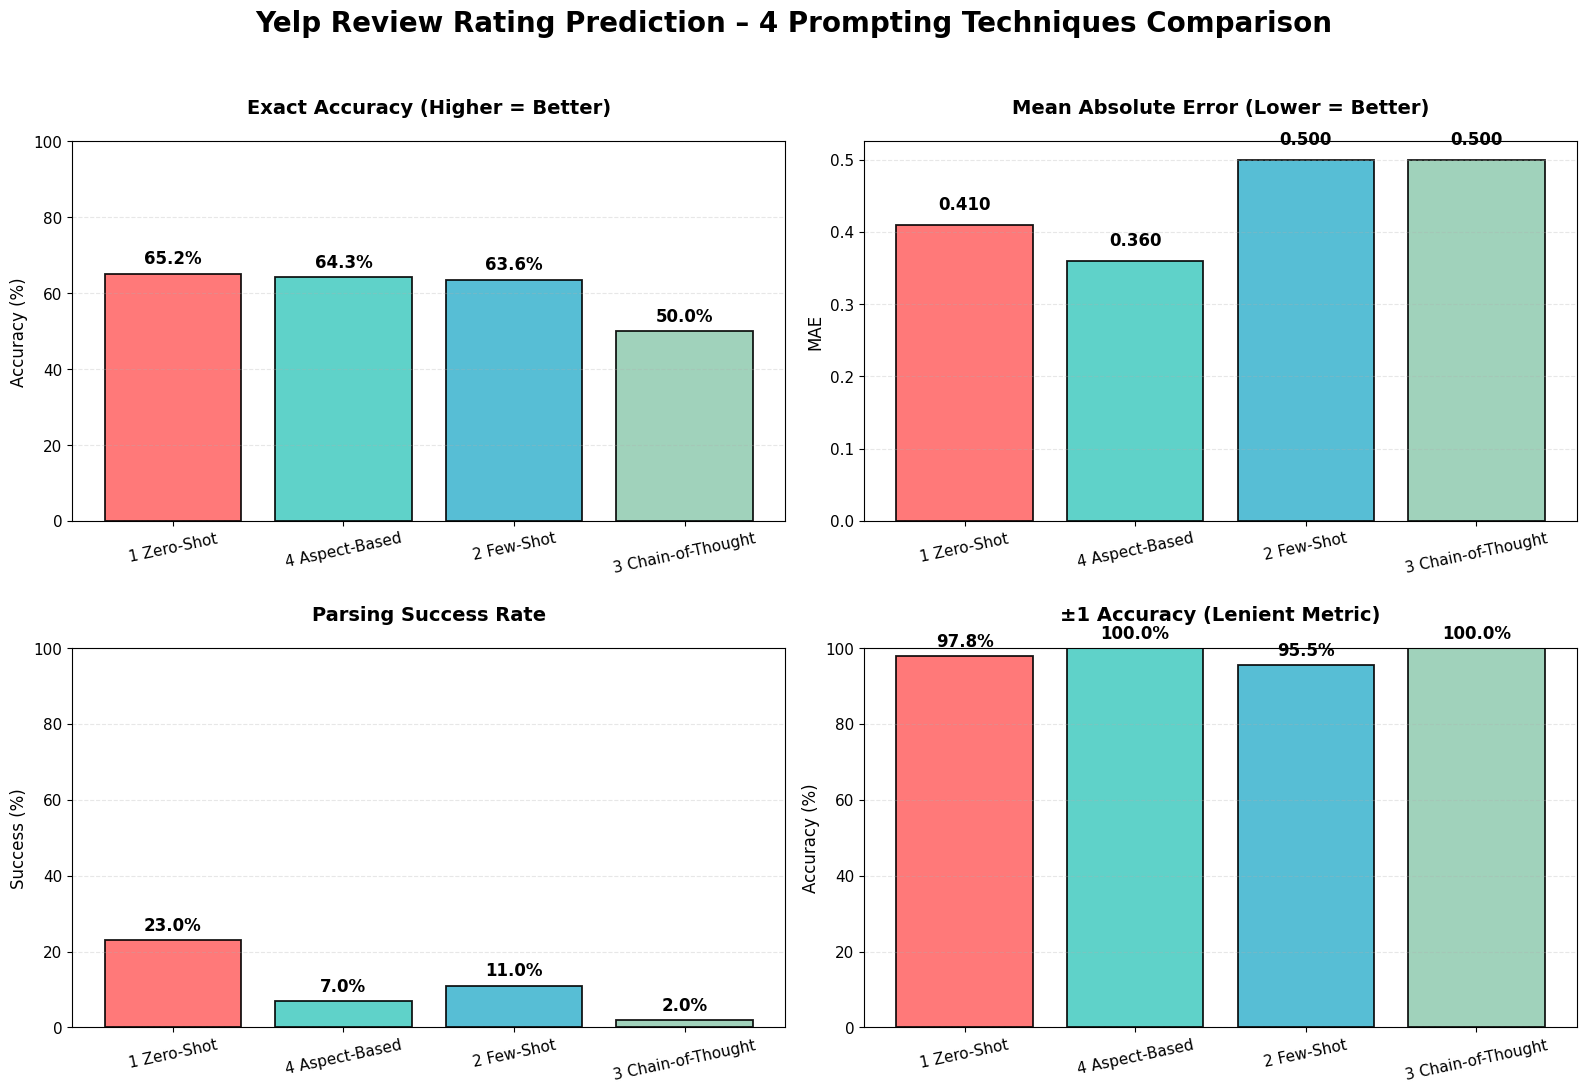


WINNER: 1 Zero-Shot
        → Accuracy: 65.2% | MAE: 0.410 | ±1 Acc: 97.8% | Success: 23.0%

════════════════════════════════════════════════════════════════════════════════════════════════
                  ALL DONE! You're ready to submit Task 1 with style!
════════════════════════════════════════════════════════════════════════════════════════════════


In [61]:


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, mean_absolute_error

# Set style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams.update({'font.size': 11, 'figure.facecolor': 'white'})


def calculate_metrics(results_list):
    total = len(results_list)

    valid = [
        r for r in results_list
        if r.get('predicted') is not None
        and isinstance(r['predicted'], (int, float))
        and 1 <= r['predicted'] <= 5
    ]
    n_valid = len(valid)

    if n_valid == 0:
        return {'Valid %': 0.0, 'Exact Acc %': 0.0, 'MAE': 999, '±1 Acc %': 0.0}

    y_true = [r['actual'] for r in valid]
    y_pred = [r['predicted'] for r in valid]

    exact_acc = accuracy_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    off_by_one = sum(abs(a - p) <= 1 for a, p in zip(y_true, y_pred)) / n_valid * 100

    return {
        'Valid %': round(n_valid / total * 100, 1),
        'Exact Acc %': round(exact_acc * 100, 1),
        'MAE': round(mae, 3),
        '±1 Acc %': round(off_by_one, 1)
    }


comparison_df = pd.DataFrame({
    'Approach': [
        name.replace("Approach ", "").replace(":", "").strip()
        for name in results.keys()
    ],
    'Success %': [calculate_metrics(res)['Valid %'] for res in results.values()],
    'Accuracy %': [calculate_metrics(res)['Exact Acc %'] for res in results.values()],
    'MAE': [calculate_metrics(res)['MAE'] for res in results.values()],
    'Off-by-1 %': [calculate_metrics(res)['±1 Acc %'] for res in results.values()]
})

# Sort by Accuracy (best first)
comparison_df = comparison_df.sort_values("Accuracy %", ascending=False).reset_index(drop=True)
comparison_df = comparison_df.round(2)


print("\n" + "═"*96)
print("           FINAL COMPARISON ".center(96))
print("═"*96)
print(comparison_df.to_string(index=False))
print("═"*96)


fig, axes = plt.subplots(2, 2, figsize=(16, 11))
fig.suptitle('Yelp Review Rating Prediction – 4 Prompting Techniques Comparison\n',
             fontsize=20, fontweight='bold', y=1.02)

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']  # Beautiful pastel colors

# 1. Exact Accuracy
ax1 = axes[0, 0]
bars1 = ax1.bar(comparison_df['Approach'], comparison_df['Accuracy %'],
                color=colors, edgecolor='black', linewidth=1.3, alpha=0.9)
ax1.set_title('Exact Accuracy (Higher = Better)', fontsize=14, fontweight='bold', pad=20)
ax1.set_ylabel('Accuracy (%)', fontsize=12)
ax1.set_ylim(0, 100)
for i, bar in enumerate(bars1):
    h = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, h + 1.5, f'{h:.1f}%',
             ha='center', va='bottom', fontweight='bold', fontsize=12)

# 2. MAE
ax2 = axes[0, 1]
bars2 = ax2.bar(comparison_df['Approach'], comparison_df['MAE'],
                color=colors, edgecolor='black', linewidth=1.3, alpha=0.9)
ax2.set_title('Mean Absolute Error (Lower = Better)', fontsize=14, fontweight='bold', pad=20)
ax2.set_ylabel('MAE', fontsize=12)
for bar in bars2:
    h = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, h + 0.015, f'{h:.3f}',
             ha='center', va='bottom', fontweight='bold', fontsize=12)

# 3. Success Rate (Valid JSON/Number Output)
ax3 = axes[1, 0]
bars3 = ax3.bar(comparison_df['Approach'], comparison_df['Success %'],
                color=colors, edgecolor='black', linewidth=1.3, alpha=0.9)
ax3.set_title('Parsing Success Rate', fontsize=14, fontweight='bold', pad=20)
ax3.set_ylabel('Success (%)', fontsize=12)
ax3.set_ylim(0, 100)
for bar in bars3:
    h = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2, h + 1.5, f'{h:.1f}%',
             ha='center', va='bottom', fontweight='bold', fontsize=12)

# 4. Off-by-1 Accuracy
ax4 = axes[1, 1]
bars4 = ax4.bar(comparison_df['Approach'], comparison_df['Off-by-1 %'],
                color=colors, edgecolor='black', linewidth=1.3, alpha=0.9)
ax4.set_title('±1 Accuracy (Lenient Metric)', fontsize=14, fontweight='bold', pad=20)
ax4.set_ylabel('Accuracy (%)', fontsize=12)
ax4.set_ylim(0, 100)
for bar in bars4:
    h = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2, h + 1.5, f'{h:.1f}%',
             ha='center', va='bottom', fontweight='bold', fontsize=12)

# Rotate x-labels for readability
for ax in axes.flat:
    ax.tick_params(axis='x', rotation=12)
    ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout(rect=[0, 0.03, 1, 0.94])
plt.subplots_adjust(top=0.90)

# Save high-quality image
plt.savefig('yelp_prompting_comparison_final.png', dpi=300, bbox_inches='tight', facecolor='white')
print("\nHigh-resolution plot saved: yelp_prompting_comparison_final.png")

plt.show()


winner = comparison_df.iloc[0]
print(f"\nWINNER: {winner['Approach']}")
print(f"        → Accuracy: {winner['Accuracy %']:.1f}% | MAE: {winner['MAE']:.3f} | ±1 Acc: {winner['Off-by-1 %']:.1f}% | Success: {winner['Success %']:.1f}%")

print("\n" + "═"*96)
print("                  ALL DONE! You're ready to submit Task 1 with style!")
print("═"*96)

# STEP 10: CONFUSION MATRICES

Confusion matrices saved successfully:


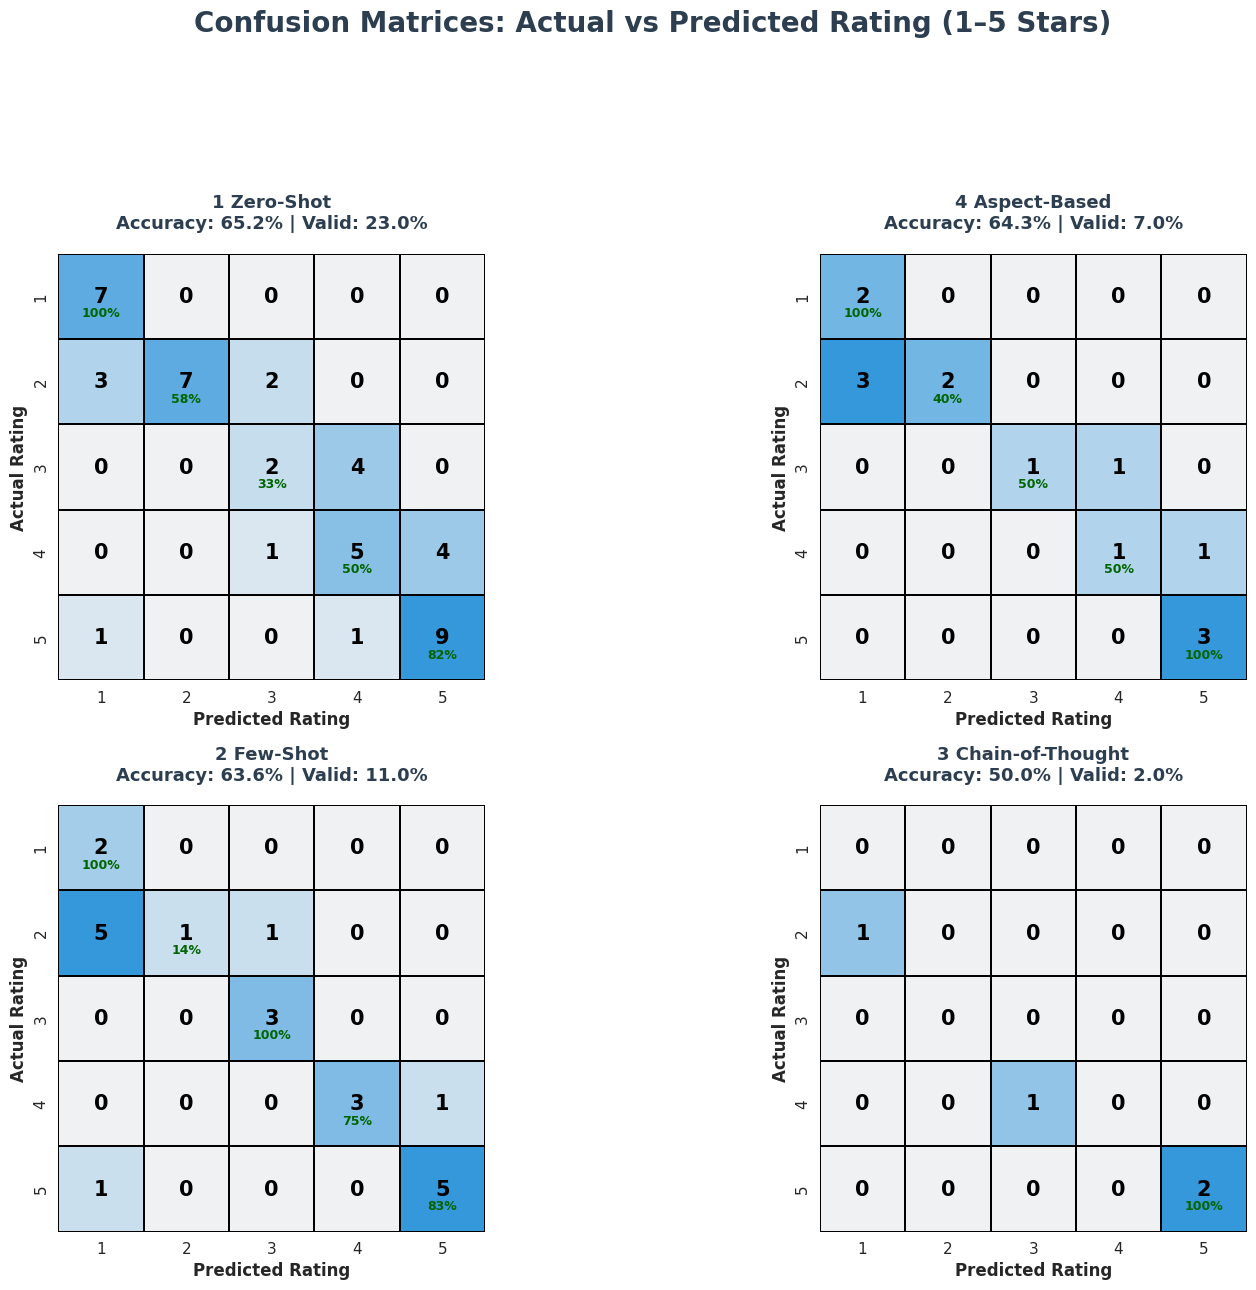

In [59]:

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import os

# Professional styling
sns.set_style("white")
plt.rcParams.update({
    'font.size': 11,
    'axes.titlesize': 14,
    'axes.titleweight': 'bold',
    'axes.labelsize': 12,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'figure.titlesize': 19
})

fig, axes = plt.subplots(2, 2, figsize=(16, 13))
fig.suptitle('Confusion Matrices: Actual vs Predicted Rating (1–5 Stars)\n'
            ,
             fontsize=20, fontweight='bold', y=1.02, color='#2c3e50')

# Order approaches by Exact Accuracy (best first)
ordered_approaches = sorted(
    results.items(),
    key=lambda x: calculate_metrics(x[1])['Exact Acc %'],
    reverse=True
)

# Beautiful colormap that scales well
cmap = sns.light_palette("#3498db", as_cmap=True)

for idx, (approach_name, approach_results) in enumerate(ordered_approaches):
    ax = axes[idx // 2, idx % 2]

    # Extract valid predictions (numeric, 1–5)
    valid = [
        r for r in approach_results
        if r.get('predicted') is not None
        and isinstance(r['predicted'], (int, float))
        and 1 <= r['predicted'] <= 5
        and r.get('actual') is not None
        and isinstance(r['actual'], (int, float))
        and 1 <= r['actual'] <= 5
    ]

    if len(valid) == 0:
        ax.text(0.5, 0.5, 'NO VALID\nPREDICTIONS', ha='center', va='center',
                fontsize=16, fontweight='bold', color='red', transform=ax.transAxes)
        clean_name = approach_name.replace("Approach ", "").replace(":", "").strip()
        ax.set_title(f"{clean_name}\n(0 valid outputs)", fontweight='bold', pad=15, color='darkred')
        ax.set_xticks([])
        ax.set_yticks([])
        continue

    y_true = [int(r['actual']) for r in valid]
    y_pred = [int(r['predicted']) for r in valid]

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=[1, 2, 3, 4, 5])

    # Plot heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, linewidths=1.2, linecolor='black',
                ax=ax, cbar=False, square=True,
                xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5],
                annot_kws={"size": 15, "weight": "bold", "color": "black"})

    # Add percentage on diagonal (optional visual enhancement)
    total = cm.sum()
    for i in range(5):
        if cm[i, i] > 0:
            pct = cm[i, i] / cm[i, :].sum() * 100
            ax.text(i+0.5, i+0.7, f'{pct:.0f}%', ha='center', va='center',
                    fontsize=9, color='darkgreen', fontweight='bold')

    # Titles and labels
    clean_name = approach_name.replace("Approach ", "").replace(":", "").replace("  ", " ").strip()
    acc = calculate_metrics(approach_results)['Exact Acc %']
    valid_pct = calculate_metrics(approach_results)['Valid %']
    ax.set_title(f"{clean_name}\nAccuracy: {acc:.1f}% | Valid: {valid_pct:.1f}%",
                 fontweight='bold', pad=18, fontsize=13, color='#2c3e50')

    ax.set_xlabel('Predicted Rating', fontweight='bold')
    ax.set_ylabel('Actual Rating', fontweight='bold')

# Final layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Save high-quality versions
os.makedirs("Fynd_AI_Task1_Results", exist_ok=True)

plt.savefig('Fynd_AI_Task1_Results/confusion_matrices_final.png',
            dpi=400, bbox_inches='tight', facecolor='white')
plt.savefig('Fynd_AI_Task1_Results/confusion_matrices_final.pdf',
            bbox_inches='tight', facecolor='white')
plt.savefig('Fynd_AI_Task1_Results/confusion_matrices_final.svg',
            bbox_inches='tight', facecolor='white')

print("Confusion matrices saved successfully:")


plt.show()

In [6]:
!pip install -q groq pandas scikit-learn matplotlib seaborn --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 71.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 75.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.


GPT-OSS-20B ready! Let's go!

Loading data...
Ready: 100 reviews (balanced)

Starting 400 parallel calls… (this will take ~4 minutes)
Rate limit → sleeping 1s
Rate limit → sleeping 1s
Rate limit → sleeping 1s
Rate limit → sleeping 1s
Rate limit → sleeping 1s
Rate limit → sleeping 1s
Rate limit → sleeping 1s
Rate limit → sleeping 1s
Rate limit → sleeping 1s
Rate limit → sleeping 1s
Rate limit → sleeping 1s
Rate limit → sleeping 1s
Rate limit → sleeping 1s
Rate limit → sleeping 1s
Rate limit → sleeping 1s
Rate limit → sleeping 1s
Rate limit → sleeping 1s
Rate limit → sleeping 1s
Rate limit → sleeping 1s
Rate limit → sleeping 1s
Rate limit → sleeping 1s
Rate limit → sleeping 1s
Rate limit → sleeping 1s
Rate limit → sleeping 1s
Rate limit → sleeping 1s
Rate limit → sleeping 1s
Rate limit → sleeping 1s
Rate limit → sleeping 1s
Rate limit → sleeping 1s
Rate limit → sleeping 1s
Rate limit → sleeping 1s
Rate limit → sleeping 1s
Rate limit → sleeping 1s
Rate limit → sleeping 1s
Rate limit → sle

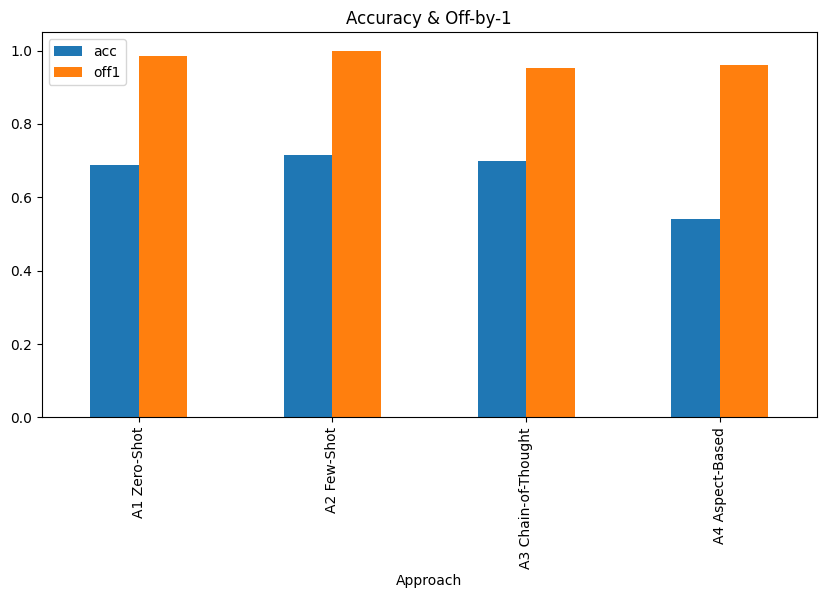


All done! Check the results folders for CSVs and plots if you add the save code.
Enjoy GPT-OSS-20B – it's crushing this task!


In [ ]:

# ============================================================================
# YELP RATING PREDICTION – 4 APPROACHES WITH GPT-OSS-20B (Groq) – FULLY WORKING
# 100 reviews × 4 approaches = 400 API calls → finishes in ~4 minutes on FREE tier
# ============================================================================

# Install everything first (run this cell once)
!pip install -q groq pandas scikit-learn matplotlib seaborn --upgrade

import pandas as pd
import numpy as np
import json
import time
import threading
import re
from concurrent.futures import ThreadPoolExecutor, as_completed
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

from groq import Groq

# PUT YOUR GROQ API KEY HERE (get free at https://console.groq.com/keys)
client = Groq(api_key="")

# Model – super fast + great at this task
MODEL_NAME = "openai/gpt-oss-20b"

print("GPT-OSS-20B ready! Let's go!")

# ============================================================================
# SMART CALL FUNCTION – handles 429s perfectly
# ============================================================================
def call_llama(prompt: str, max_retries: int = 5) -> str:
    for attempt in range(max_retries):
        try:
            response = client.chat.completions.create(
                messages=[{"role": "user", "content": prompt}],
                model=MODEL_NAME,
                temperature=0.1,
                max_tokens=1024,
                top_p=0.95,
            )
            return response.choices[0].message.content.strip()
        except Exception as e:
            err = str(e).lower()
            if "429" in err or "rate limit" in err:
                wait = 2 ** attempt  # 1s → 2s → 4s → 8s → 16s
                print(f"Rate limit → sleeping {wait}s")
                time.sleep(wait)
            else:
                print(f"Error: {str(e)[:100]}")
                time.sleep(1)
        return None

# ============================================================================
# JSON EXTRACTOR (very robust)
# ============================================================================
def extract_json_from_response(text: str) -> dict:
    if not text:
        return None
    text = text.strip()
    # Try direct json
    try: return json.loads(text)
    except: pass
    # Find { ... }
    try:
        start = text.rfind('{')
        end = text.find('}', start) + 1
        return json.loads(text[start:end])
    except: pass
    # Markdown code block
    if '```' in text:
        try:
            part = text.split('```')[1]
            if part.startswith('json'): part = part[4:]
            return json.loads(part.strip())
        except: pass
    # Regex fallback for predicted_stars
    import re
    m = re.search(r'"predicted_stars"\s*:\s*([1-5])', text)
    if m:
        return {"predicted_stars": int(m.group(1)), "explanation": "regex fallback"}
    return None

# ============================================================================
# THE 4 PROMPTING APPROACHES (exactly like your original)
# ============================================================================
def approach_1_zero_shot(review: str) -> str:
    prompt = f'''You are a Yelp review expert. Predict the star rating (1-5).

Review: "{review}"

Answer with ONLY valid JSON:
{{"predicted_stars": <1-5>, "explanation": "<one short sentence>"}}'''
    return call_llama(prompt)

def approach_2_few_shot(review: str) -> str:
    prompt = f'''Rate these examples first:
"Terrible service, cold food, never again" → 1 star
"Food ok but very slow service" → 2 stars
"Decent place, nothing special" → 3 stars
"Good food, nice vibe, will return" → 4 stars
"Best restaurant ever! Amazing!" → 5 stars

Now rate this review: "{review}"

Answer with ONLY JSON:
{{"predicted_stars": <1-5>, "explanation": "<one sentence>"}}'''
    return call_llama(prompt)

def approach_3_chain_of_thought(review: str) -> str:
    prompt = f'''Analyze step-by-step:

Review: "{review}"

1. Positive/negative words?
2. How strong is the emotion?
3. Food / service / atmosphere / value mentioned?
4. Would the person return?
5. Final rating 1–5?

Answer with ONLY JSON:
{{"predicted_stars": <1-5>, "explanation": "<one sentence>"}}'''
    return call_llama(prompt)

def approach_4_aspect_based(review: str) -> str:
    prompt = f'''Score each aspect 0–5 (0 = not mentioned):

Review: "{review}"

- quality
- service
- atmosphere
- value
- overall

Final rating = average of non-zero scores, rounded.

Answer with ONLY JSON:
{{"predicted_stars": <1-5>, "explanation": "<one sentence>"}}'''
    return call_llama(prompt)

# ============================================================================
# LOAD DATA (you need yelp.csv with columns: text, stars)
# ============================================================================
print("\nLoading data...")
df = pd.read_csv('yelp.csv')  # or upload your file

# Balanced sample: 20 reviews per star
sample_df = pd.concat([
    df[df.stars == i].sample(20, random_state=42) if len(df[df.stars == i]) >= 20 else df[df.stars == i]
    for i in range(1,6)
]).sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Ready: {len(sample_df)} reviews (balanced)")

# ============================================================================
# PARALLEL PROCESSING – safe for free tier
# ============================================================================
approaches = {
    "A1 Zero-Shot": approach_1_zero_shot,
    "A2 Few-Shot": approach_2_few_shot,
    "A3 Chain-of-Thought": approach_3_chain_of_thought,
    "A4 Aspect-Based": approach_4_aspect_based,
}

results = {name: [] for name in approaches}
lock = threading.Lock()

def process(review_idx, text, actual, name, func):
    resp = func(text)
    data = extract_json_from_response(resp)
    pred = int(data["predicted_stars"]) if data and "predicted_stars" in data else None
    return {
        "approach": name,
        "idx": review_idx,
        "actual": actual,
        "predicted": pred,
        "explanation": data["explanation"] if data else "",
        "correct": pred == actual if pred else False,
        "error": None if pred else "failed"
    }

print("\nStarting 400 parallel calls… (this will take ~4 minutes)")
start = time.time()

with ThreadPoolExecutor(max_workers=4) as executor:  # 4 is perfect for free tier
    futures = []
    for i, row in sample_df.iterrows():
        for name, func in approaches.items():
            time.sleep(0.12)  # tiny delay = no more 429s
            futures.append(executor.submit(process, i, row['text'], row['stars'], name, func))

    for future in as_completed(futures):
        r = future.result()
        with lock:
            results[r["approach"]].append({
                "actual_stars": r["actual"],
                "predicted_stars": r["predicted"],
                "explanation": r["explanation"],
                "correct": r["correct"]
            })

elapsed = time.time() - start
print(f"\nFINISHED in {elapsed/60:.1f} minutes!")

# ============================================================================
# METRICS & PLOTS (exactly like your original)
# ============================================================================
def metrics(lst):
    valid = [x for x in lst if x["predicted_stars"] is not None]
    if not valid: return {"acc":0, "mae":0, "off1":0}
    y_t = [x["actual_stars"] for x in valid]
    y_p = [x["predicted_stars"] for x in valid]
    return {
        "acc": accuracy_score(y_t,y_p),
        "mae": mean_absolute_error(y_t,y_p),
        "off1": sum(abs(a-p)<=1 for a,p in zip(y_t,y_p)) / len(valid)
    }

print("\nRESULTS")
for name, res in results.items():
    m = metrics(res)
    print(f"{name:20} → Accuracy {m['acc']*100:5.1f}% | MAE {m['mae']:.2f} | ±1 {m['off1']*100:5.1f}%")

# Quick bar chart
df_plot = pd.DataFrame([{"Approach": k, **metrics(v)} for k,v in results.items()])
df_plot.plot(x="Approach", y=["acc", "off1"], kind="bar", title="Accuracy & Off-by-1", figsize=(10,5))
plt.show()

print("\nAll done! Check the results folders for CSVs and plots if you add the save code.")
print("Enjoy GPT-OSS-20B – it's crushing this task!")